In [1]:
import sys
sys.path.append('/home/xinyiz/pamrats')

In [2]:
import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim

import gae.gae.optimizer as optimizer
import gae.gae.model
import gae.gae.preprocessing as preprocessing

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances

In [3]:
# Settings
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
use_cuda=True
fastmode=False #Validate during training pass
seed=3
useSavedMaskedEdges=True
maskedgeName='knn20_connectivity'
epochs=10000
saveFreq=30
lr=0.001 #initial learning rate
lr_adv=0.001
weight_decay=0 #Weight for L2 loss on embedding matrix.

hidden1=5000 #Number of units in hidden layer 1
hidden2=5000 #Number of units in hidden layer 2
# hidden3=2048
# hidden4=2048
# hidden5=128
fc_dim1=5000
# fc_dim2=128
# fc_dim3=128
# fc_dim4=128
# gcn_dim1=2600
# clf_hidden=256
adv_hidden=128

dropout=0.01
testNodes=0.1 #fraction of total nodes for testing
valNodes=0.05 #fraction of total nodes for validation
XreconWeight=20
# clfweight=20
advWeight=2
# randFeatureSubset=None
model_str='gcn_vae_xa_e2_d1_dca'
clf=None
adv=None  #'clf_fc1_eq'  #'clf_fc1_control_eq' #'clf_fc1_control'  #'clf_fc1'
protein=None #'nearest' #None #'scaled_binary'
plaqueMaskName='PlaqueMask'
proteinWeights=0.001
adj_decodeName=None #gala or None
ridgeL=0.01
shareGenePi=True

pretrainedAE=None #{'name':'controlphy5XAbin_01_dca','epoch':9990}
num_features=2112
# training_samples=['control13','disease13','disease8']###rename and retrain C8
# training_samples=['disease13','control13','disease8']
training_samples=['control13','disease13','control8','disease8']
targetBatch=None
training_sample_X='logminmax'
switchFreq=10
standardizeX=False
# name='allk20XA_01_dca_noD8' ###rename and retrain D8 C8
name='allk20XA_05_dca_over_lossXreconOnly_wKL'
useA=False #set to True to include adjacency loss
logsavepath='/mnt/external_ssd/xinyi/log/train_gae_starmap/'+name
modelsavepath='/mnt/external_ssd/xinyi/models/train_gae_starmap/'+name
plotsavepath='/mnt/external_ssd/xinyi/plots/train_gae_starmap/'+name
datadir='/home/xinyiz/2021-01-13-mAD-test-dataset'

#Load data
sampleidx={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}
savedir=os.path.join('/home/xinyiz/starmap')
adj_dir=os.path.join(savedir,'a')

featureslist={}
if training_sample_X in ['corrected','scaled']:
    scaleddata=scanpy.read_h5ad(datadir+'/2020-12-27-starmap-mAD-scaled.h5ad')
    
    for s in sampleidx.keys():
        featureslist[s+'X_'+'corrected']=torch.tensor(scaleddata.layers['corrected'][scaleddata.obs['sample']==sampleidx[s]])
        featureslist[s+'X_'+'scaled']=torch.tensor(scaleddata.layers['scaled'][scaleddata.obs['sample']==sampleidx[s]])

else:
    scaleddata=scanpy.read_h5ad(datadir+'/2020-12-27-starmap-mAD-raw.h5ad')
    
    for s in sampleidx.keys():
        scaleddata_train=scaleddata.X[scaleddata.obs['sample']==sampleidx[s]]

        if training_sample_X=='logminmax':
            featurelog_train=np.log2(scaleddata_train+1/2)
            scaler = MinMaxScaler()
            featurelog_train_minmax=np.transpose(scaler.fit_transform(np.transpose(featurelog_train)))
            featureslist[s+'X_'+training_sample_X]=torch.tensor(featurelog_train_minmax)
        elif training_sample_X=='logminmax10':
            featurelog_train=np.log2(scaleddata_train+1/2)
            scaler = MinMaxScaler(feature_range=(0,10))
            featurelog_train_minmax=np.transpose(scaler.fit_transform(np.transpose(featurelog_train)))
            featureslist[s+'X_'+training_sample_X]=torch.tensor(featurelog_train_minmax)

if protein:
    if protein=='scaled_binary':
        proteinsavepath=os.path.join('/mnt/xinyi/','starmap','protein')
        for s in sampleidx.keys():
            pmtx=sp.load_npz(os.path.join(proteinsavepath,sampleidx[s]+'_'+protein+'.npz'))
            pmtx=preprocessing.sparse_mx_to_torch_sparse_tensor(pmtx)
            pmtx=pmtx.to_dense()
            scalefactor=torch.sum(featureslist[s+'X_'+training_sample_X])/torch.sum(pmtx)*proteinWeights
            featureslist[s+'X_'+training_sample_X]=torch.cat((featureslist[s+'X_'+training_sample_X],pmtx*scalefactor),dim=1)
    if protein =='nearest':
        for s in sampleidx.keys():
            if 'control' in s:
                featureslist[s+'X_'+training_sample_X]=torch.cat((featureslist[s+'X_'+training_sample_X],torch.zeros((featureslist[s+'X_'+training_sample_X].shape[0],1))),dim=1)
            elif 'disease' in s:
                pmtx=torch.zeros((featureslist[s+'X_'+training_sample_X].shape[0],1))
                plaqueCentroids=pd.read_csv('/home/xinyiz/2021-01-13-mAD-test-dataset/'+sampleidx[s]+'/trimmed_images/'+plaqueMaskName+'.csv', header=0)
                cellPlaqueDist=pairwise_distances((scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx[s],['x','y']].to_numpy())/0.3,plaqueCentroids[['X','Y']])
                cellidx=np.argmin(cellPlaqueDist,axis=0)
                for c in range(cellidx.size):
                    pmtx[cellidx[c],0]+=plaqueCentroids['Area'][c]
                if s=='disease13':
                    scalefactor=torch.sum(featureslist[s+'X_'+training_sample_X])/torch.sum(pmtx)*proteinWeights
                featureslist[s+'X_'+training_sample_X]=torch.cat((featureslist[s+'X_'+training_sample_X],pmtx*scalefactor),dim=1)

        
if clf:
    ctlist={}
    ctlist['disease13']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9494','top_level'].to_numpy()
    ctlist['control13']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9498','top_level'].to_numpy()
    ctlist['disease8']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9723','top_level'].to_numpy()
    ctlist['control8']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9735','top_level'].to_numpy()
    ct_unique=np.unique(scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9735','top_level'])
    for k in ctlist.keys():
        for i in range(ct_unique.size):
            ctlist[k][ctlist[k]==ct_unique[i]]=i
    
adj_list={}
adj_list['disease13']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9494.npz'))
adj_list['control13']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9498.npz'))
adj_list['disease8']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9723.npz'))
adj_list['control8']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9735.npz'))

adjnormlist={}
pos_weightlist={}
normlist={}
for ai in adj_list.keys():
    adjnormlist[ai]=preprocessing.preprocess_graph(adj_list[ai])
    
    pos_weightlist[ai] = torch.tensor(float(adj_list[ai].shape[0] * adj_list[ai].shape[0] - adj_list[ai].sum()) / adj_list[ai].sum()) #using full unmasked adj
    normlist[ai] = adj_list[ai].shape[0] * adj_list[ai].shape[0] / float((adj_list[ai].shape[0] * adj_list[ai].shape[0] - adj_list[ai].sum()) * 2)
    
    adj_label=adj_list[ai] + sp.eye(adj_list[ai].shape[0])
    adj_list[ai]=torch.tensor(adj_label.todense())
    
if adv:
    if 'control_eq' in adv:
        sampleLabellist_ae={}
        sampleLabellist_ae['control13']=torch.tensor([0.5,0.5]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_ae['control8']=torch.tensor([0.5,0.5]).expand(adjnormlist['control8'].shape[0],-1)

        sampleLabellist_d={}
        sampleLabellist_d['control13']=torch.tensor([1,0]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_d['control8']=torch.tensor([0,1]).expand(adjnormlist['control8'].shape[0],-1)
    elif 'control' in adv:
        sampleLabellist_ae={}
        sampleLabellist_ae['control13']=torch.tensor([0,1]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_ae['control8']=torch.tensor([1,0]).expand(adjnormlist['control8'].shape[0],-1)

        sampleLabellist_d={}
        sampleLabellist_d['control13']=torch.tensor([1,0]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_d['control8']=torch.tensor([0,1]).expand(adjnormlist['control8'].shape[0],-1)        
    elif 'eq' in adv:
        sampleLabellist_ae={}
        sampleLabellist_ae['disease13']=torch.tensor([0.5,0.5,0.5,0.5]).expand(adjnormlist['disease13'].shape[0],-1)
        sampleLabellist_ae['control13']=torch.tensor([0.5,0.5,0.5,0.5]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_ae['disease8']=torch.tensor([0.5,0.5,0.5,0.5]).expand(adjnormlist['disease8'].shape[0],-1)
        sampleLabellist_ae['control8']=torch.tensor([0.5,0.5,0.5,0.5]).expand(adjnormlist['control8'].shape[0],-1)

        sampleLabellist_d={}
        sampleLabellist_d['disease13']=torch.tensor([1,0,0,0]).expand(adjnormlist['disease13'].shape[0],-1)
        sampleLabellist_d['control13']=torch.tensor([0,1,0,0]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_d['disease8']=torch.tensor([0,0,1,0]).expand(adjnormlist['disease8'].shape[0],-1)
        sampleLabellist_d['control8']=torch.tensor([0,0,0,1]).expand(adjnormlist['control8'].shape[0],-1)
    else:
        sampleLabellist_ae={}
        sampleLabellist_ae['disease13']=torch.tensor([0,1,1,1]).expand(adjnormlist['disease13'].shape[0],-1)
        sampleLabellist_ae['control13']=torch.tensor([1,0,1,1]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_ae['disease8']=torch.tensor([1,1,0,1]).expand(adjnormlist['disease8'].shape[0],-1)
        sampleLabellist_ae['control8']=torch.tensor([1,1,1,0]).expand(adjnormlist['control8'].shape[0],-1)

        sampleLabellist_d={}
        sampleLabellist_d['disease13']=torch.tensor([1,0,0,0]).expand(adjnormlist['disease13'].shape[0],-1)
        sampleLabellist_d['control13']=torch.tensor([0,1,0,0]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_d['disease8']=torch.tensor([0,0,1,0]).expand(adjnormlist['disease8'].shape[0],-1)
        sampleLabellist_d['control8']=torch.tensor([0,0,0,1]).expand(adjnormlist['control8'].shape[0],-1)
        
    
        
    
# adj_decode=None
# if adj_decodeName == 'gala':
#     adj_decode=preprocessing.preprocess_graph_sharp(adj_train)



if 'dca' in model_str:
    rawdata=scanpy.read_h5ad(datadir+'/2020-12-27-starmap-mAD-raw.h5ad')
    features_raw_list={}
    for s in sampleidx.keys():
#         features_raw_list[s+'X_'+'raw']=torch.tensor(rawdata.X[rawdata.obs['sample']==sampleidx[s]]).cuda()
        features_raw_list[s+'X_'+'raw']=torch.tensor(rawdata.X[rawdata.obs['sample']==sampleidx[s]])
        if protein:
            if protein=='scaled_binary':
                proteinsavepath=os.path.join('/mnt/xinyi/','starmap','protein')
                pmtx=sp.load_npz(os.path.join(proteinsavepath,sampleidx[s]+'_'+protein+'.npz'))
                pmtx=preprocessing.sparse_mx_to_torch_sparse_tensor(pmtx)
                pmtx=pmtx.to_dense()
                scalefactor=torch.sum(features_raw_list[s+'X_raw'])/torch.sum(pmtx)*proteinWeights
                features_raw_list[s+'X_raw']=torch.cat((features_raw_list[s+'X_raw'],pmtx*scalefactor),dim=1)
            if protein=='nearest':
                features_raw_list[s+'X_raw']=torch.cat((features_raw_list[s+'X_raw'],featureslist[s+'X_'+training_sample_X][:,2112:2113]),dim=1)

if clf:
    ct_train=ctlist[training_samples].astype(int)
# features=torch.tensor(np.identity(7000)).float()
# features=features[0:10,:]
if standardizeX:
    features=torch.tensor(scale(features,axis=0, with_mean=True, with_std=True, copy=True))

# Set cuda and seed
np.random.seed(seed)
if use_cuda and (not torch.cuda.is_available()):
    print('cuda not available')
    use_cuda=False
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True

# Load data
# if randFeatureSubset != None:
#     idx=np.random.choice(features.shape[1],randFeatureSubset,replace=False)
#     features=features[:,idx]


0
0
0
0


In [4]:
if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)

In [5]:
# loop over all train/validation sets
np.random.seed(seed)
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True
    
mse=torch.nn.MSELoss()
# mse=torch.nn.MSELoss(reduction=None)
# Create model
if model_str=='gcn_vae_xa':
    model = gae.gae.model.GCNModelVAE_XA(num_features, hidden1, hidden2,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
elif model_str == 'gcn_vae_gcnX_inprA':
    model = gae.gae.model.GCNModelVAE_gcnX_inprA(num_features, hidden1, hidden2,gcn_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
    
elif model_str == 'gcn_vae_gcnX_inprA_w':
    model = gae.gae.model.GCNModelVAE_gcnX_inprA_w(num_features, hidden1, hidden2,gcn_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE    
    
elif model_str=='gcn_vae_xa_e3':
    model = gae.gae.model.GCNModelVAE_XA_e3(num_features, hidden1, hidden2,hidden3,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
    
elif model_str == 'gcn_vae_xa_e1':
    model = gae.gae.model.GCNModelVAE_XA_e1(num_features, hidden1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE

elif model_str == 'gcn_vae_xa_e2_d1':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1(num_features, hidden1,hidden2, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
    
elif model_str=='gcn_vae_xa_e2_d1_dca':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCA(num_features, hidden1,hidden2,fc_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE

elif model_str=='gcn_vae_xa_e2_d1_dca_fca':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCA_fca(num_features, hidden1,hidden2,fc_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE
    
elif model_str=='gcn_vae_xa_e2_d1_dcaFork':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCAfork(num_features, hidden1,hidden2,fc_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE

elif model_str=='gcn_vae_xa_e2_d1_dcaElemPi':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCAelemPi(num_features, hidden1,hidden2,fc_dim1, dropout,shareGenePi)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE

elif model_str=='gcn_vae_xa_e2_d1_dcaConstantDisp':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCA_constantDisp(num_features, hidden1,hidden2,fc_dim1, dropout,shareGenePi)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE    
    
elif model_str == 'gcn_vae_xa_e4_d1':
    model = gae.gae.model.GCNModelVAE_XA_e4_d1(num_features, hidden1,hidden2,hidden3,hidden4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE    
    
elif model_str=='fc':
    model = gae.gae.model.FCVAE(num_features, hidden1, hidden2,hidden3,hidden4,hidden5,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
#     loss_x=mse
    loss_a=optimizer.optimizer_CE
elif model_str=='fcae':
    model = gae.gae.model.FCAE(num_features, hidden1, hidden2,hidden3,hidden4,hidden5,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_x=optimizer.optimizer_MSE
#     loss_x=mse

elif model_str=='fcae1':
    model = gae.gae.model.FCAE1(num_features, dropout,hidden1)
    loss_x=optimizer.optimizer_MSE
#     loss_x=mse
elif model_str=='fcae2':
    model = gae.gae.model.FCAE2(num_features, dropout,hidden1,hidden2)
    loss_x=optimizer.optimizer_MSE

elif model_str=='fc1':
    model = gae.gae.model.FCVAE1(num_features, hidden1,dropout)
    loss_x=optimizer.optimizer_MSE
    loss_kl=optimizer.optimizer_kl
    loss_a=optimizer.optimizer_CE

elif model_str=='fc1_fca':
    model = gae.gae.model.FCVAE1_fca(num_features, hidden1,dropout)
    loss_x=optimizer.optimizer_MSE
    loss_kl=optimizer.optimizer_kl
    loss_a=optimizer.optimizer_CE    
    
elif model_str=='fc1_dca':
    model = gae.gae.model.FCVAE1_DCA(num_features, hidden1,fc_dim1, dropout)
    loss_x=optimizer.optimizer_zinb
    loss_kl=optimizer.optimizer_kl
    loss_a=optimizer.optimizer_CE

if clf=='clf_fc1':
    modelClf=gae.gae.model.Clf_fc1(hidden2, dropout,clf_hidden,ct_unique.size)
    loss_clf=torch.nn.CrossEntropyLoss()
    
if adv=='clf_fc1' or adv=='clf_fc1_eq' or adv=='clf_fc1_control' or adv=='clf_fc1_control_eq':
    modelAdv=gae.gae.model.Clf_fc1(hidden2, dropout,adv_hidden,sampleLabellist_ae['control13'].size()[1])
    loss_adv=optimizer.optimizer_CEclf
    
if adv=='clf_linear1' or adv=='clf_linear1_control':
    modelAdv=gae.gae.model.Clf_linear1(hidden2, dropout,sampleLabellist_ae['control13'].size()[1])
    loss_adv=optimizer.optimizer_CEclf
    
if 'NB' in name:
    print('using NB loss for X')
    loss_x=optimizer.optimizer_nb
    
if use_cuda:
    model.cuda()
    if clf:
        modelClf.cuda()
        ct_train=torch.tensor(ct_train).cuda()
    if adv:
        modelAdv.cuda()
#         for sk in sampleLabellist_ae.keys():
#             sampleLabellist_ae[sk]=sampleLabellist_ae[sk].cuda().float()
#             sampleLabellist_d[sk]=sampleLabellist_d[sk].cuda().float()
#     for fk in featureslist.keys():
#         featureslist[fk] = featureslist[fk].cuda().float()
#     for ak in adj_list.keys():
#         adjnormlist[ak] =adjnormlist[ak].cuda()
#         adj_list[ak] = adj_list[ak].cuda().float()
#     if adj_decode is not None:
#         adj_decode=adj_decode.cuda()
    

optimizerVAEXA = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
if clf:
    optimizerClf=optim.Adam(modelClf.parameters(), lr=lr, weight_decay=weight_decay)
if adv:
    optimizerAdv=optim.Adam(modelAdv.parameters(), lr=lr_adv, weight_decay=weight_decay)    


In [9]:
# model.load_state_dict(torch.load(os.path.join(modelsavepath,str(9360)+'.pt')))
# epochs=20000
if pretrainedAE:
    print('loading '+pretrainedAE['name']+' epoch '+str(pretrainedAE['epoch']))
    model.load_state_dict(torch.load(os.path.join('/mnt/xinyi/pamrats/models/train_gae_starmap/'+pretrainedAE['name'],str(pretrainedAE['epoch'])+'.pt')))
model.load_state_dict(torch.load(os.path.join(modelsavepath,str(5910)+'.pt')))
# model.cuda()
def train(epoch):
    t = time.time()
    model.train()
    optimizerVAEXA.zero_grad()
    
    if adj_decodeName==None:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm)
    #     features_recon, z, mu, logvar=model(features.float())
    else:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm,adj_decode)
        
    
    if clf:
        modelClf.train()
        optimizerClf.zero_grad()
        clfOut=modelClf(z)
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
        modelAdv.eval()
        advOut=modelAdv(z)
    
    loss_kl_train=loss_kl(mu, logvar, train_nodes_idx)
    
    if 'dca' in model_str:
        if 'NB' in name:
            loss_x_train=loss_x(features_recon, features,train_nodes_idx,XreconWeight)
        else:
            loss_x_train=loss_x(features_recon, features,train_nodes_idx,XreconWeight,ridgeL,features_raw)
    else:
        loss_x_train=loss_x(features_recon, features,train_nodes_idx,XreconWeight,mse)
    
    if protein:
        loss_p_train=loss_x((features_recon[0][:,2112:2113],features_recon[1][:,2112:2113],features_recon[2][:,2112:2113],features_recon[3][:,2112:2113]), features[:,2112:2113],train_nodes_idx,XreconWeight,ridgeL,features_raw[:,2112:2113])
    loss_a_train=loss_a(adj_recon, adj_label, pos_weight, norm,train_nodes_idx)
    
    
#     loss = loss_kl_train+loss_x_train+loss_a_train
#     loss=loss_x_train #for lossXreconOnly only
    loss=loss_kl_train+loss_x_train #for lossXreconOnly_wKL only
    if useA:
        loss=loss+loss_a_train
#     loss = loss_kl_train+loss_a_train #for lossAreconOnly_wKL only
    if clf:
        loss_clf_train=loss_clf(clfOut[train_nodes_idx],ct_train[train_nodes_idx])
        loss=loss+clfweight*loss_clf_train
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
        loss_adv_train=loss_adv(advOut,sampleLabel_ae,train_nodes_idx)
        loss+=loss_adv_train*advWeight
    loss.backward()
    optimizerVAEXA.step()
    if clf:
        optimizerClf.step()

    if not fastmode:
        # Evaluate validation set performance separately,
        # deactivates dropout during validation run & no variation in z.
        model.eval()
        if adj_decodeName==None:
            adj_recon,mu,logvar,z, features_recon = model(features, adj_norm)
    #         features_recon, z, mu, logvar=model(features.float())
        else:
            adj_recon,mu,logvar,z, features_recon = model(features, adj_norm,adj_decode)
    
    if clf:
        modelClf.eval()
        clfOut=modelClf(z)
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
        advOut=modelAdv(z)
    if 'dca' in model_str:
        if 'NB' in name:
            loss_x_val=loss_x(features_recon, features,val_nodes_idx,XreconWeight)
        else:
            loss_x_val=loss_x(features_recon, features,val_nodes_idx,XreconWeight,ridgeL,features_raw)
    else:
        loss_x_val=loss_x(features_recon, features,val_nodes_idx,XreconWeight,mse)
    
    if protein:
        loss_p_val=loss_x((features_recon[0][:,2112:2113],features_recon[1][:,2112:2113],features_recon[2][:,2112:2113],features_recon[3][:,2112:2113]), features[:,2112:2113],val_nodes_idx,XreconWeight,ridgeL,features_raw[:,2112:2113])

#     features_recon=None
#     torch.cuda.empty_cache()
    
    loss_a_val=loss_a(adj_recon, adj_label, pos_weight, norm,val_nodes_idx)
    
#     adj_recon=None
# #     val_nodes_idx=None
#     torch.cuda.empty_cache()
    
#     loss_val = loss_x_val+loss_a_val
    loss_val=loss_x_val
    if useA:
        loss_val=loss_val+loss_a_val
#     loss_val=loss_a_val
    if clf:
        loss_clf_val=loss_clf(clfOut[val_nodes_idx],ct_train[val_nodes_idx])
        loss_val=loss_val+clfweight*loss_clf_val
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
        loss_adv_val=loss_adv(advOut,sampleLabel_ae,val_nodes_idx)
        loss_val+=loss_adv_val*advWeight
#     print(features_recon[:5,:5])
    print(training_samples_t+' Epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss.item()),
          'loss_kl_train: {:.4f}'.format(loss_kl_train.item()),
          'loss_x_train: {:.4f}'.format(loss_x_train.item()),
          'loss_a_train: {:.4f}'.format(loss_a_train.item()),
#           'loss_clf_train: {:.4f}'.format(loss_clf_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'loss_x_val: {:.4f}'.format(loss_x_val.item()),
          'loss_a_val: {:.4f}'.format(loss_a_val.item()),
#           'loss_clf_val: {:.4f}'.format(loss_clf_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
        print('loss_adv_train: {:.4f}'.format(loss_adv_train.item()),
              'loss_adv_val: {:.4f}'.format(loss_adv_val.item())
             )
    if protein:
        print('loss_p_train: {:.4f}'.format(loss_p_train.item()),
              'loss_p_val: {:.4f}'.format(loss_p_val.item())
             )
#     return loss.item(),loss_x_train.item(),loss_val.item(),loss_x_val.item()
#     return loss.item(),loss_kl_train.item(),loss_x_train.item(),loss_val.item(),loss_x_val.item()
    if protein:
        return loss.item(),loss_kl_train.item(),loss_x_train.item(),loss_a_train.item(),loss_p_train.item(),loss_val.item(),loss_x_val.item(),loss_a_val.item(),loss_p_val.item()       
    if clf:
        return loss.item(),loss_kl_train.item(),loss_x_train.item(),loss_a_train.item(),loss_val.item(),loss_x_val.item(),loss_a_val.item(),loss_clf_train.item(),loss_clf_val.item()
    elif adv:
        if (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
            return float(loss),float(loss_kl_train),float(loss_x_train),float(loss_a_train),float(loss_val),float(loss_x_val),float(loss_a_val),float(loss_adv_train),float(loss_adv_val)        
        else:
            return float(loss),float(loss_kl_train),float(loss_x_train),float(loss_a_train),float(loss_val),float(loss_x_val),float(loss_a_val),None,None   
    else:
        return loss.item(),loss_kl_train.item(),loss_x_train.item(),loss_a_train.item(),loss_val.item(),loss_x_val.item(),loss_a_val.item()        

def train_discriminator(epoch):
    t = time.time()
    model.eval()
    
    if adj_decodeName==None:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm)
    #     features_recon, z, mu, logvar=model(features.float())
    else:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm,adj_decode)
        
    
    if clf:
        modelClf.eval()
        clfOut=modelClf(z)
        
    modelAdv.train()
    optimizerAdv.zero_grad()
    advOut=modelAdv(z)
    
    loss_adv_train=loss_adv(advOut,sampleLabel_d,train_nodes_idx)
    loss = loss_adv_train*advWeight
    
    loss.backward()
    optimizerAdv.step()

    modelAdv.eval()
    advOut=modelAdv(z)
    loss_adv_val=loss_adv(advOut,sampleLabel_d,val_nodes_idx)
    loss_val=loss_adv_val*advWeight
    print(training_samples_t+' Epoch: {:04d}'.format(epoch),
          'loss_adv_train: {:.4f}'.format(loss_adv_train.item()),
          'loss_adv_val: {:.4f}'.format(loss_adv_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
    return float(loss_adv_train),float(loss_adv_val)
    
# print('cross-validation ',seti)
train_loss_ep=[None]*epochs
train_loss_kl_ep=[None]*epochs
train_loss_x_ep=[None]*epochs
train_loss_a_ep=[None]*epochs
train_loss_clf_ep=[None]*epochs
train_loss_adv_ep=[None]*epochs
train_loss_advD_ep=[None]*epochs
val_loss_ep=[None]*epochs
val_loss_x_ep=[None]*epochs
val_loss_a_ep=[None]*epochs
val_loss_clf_ep=[None]*epochs
val_loss_adv_ep=[None]*epochs
val_loss_advD_ep=[None]*epochs
if protein:
    train_loss_p_ep=[None]*epochs
    val_loss_p_ep=[None]*epochs
t_ep=time.time()

for ep in range(5911,epochs):
# for ep in range(10000,20000):
    t=int(ep/switchFreq)%len(training_samples)
    training_samples_t=training_samples[t]
    
#     adj_norm=adjnormlist[training_samples_t]
#     adj_label=adj_list[training_samples_t]
#     features=featureslist[training_samples_t+'X_'+training_sample_X]
    adj_norm=adjnormlist[training_samples_t].cuda().float()
    adj_label=adj_list[training_samples_t].cuda().float()
    features=featureslist[training_samples_t+'X_'+training_sample_X].cuda().float()
    pos_weight=pos_weightlist[training_samples_t]
    norm=normlist[training_samples_t]
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())):
#         sampleLabel_ae=sampleLabellist_ae[training_samples_t]
#         sampleLabel_d=sampleLabellist_d[training_samples_t]
        sampleLabel_ae=sampleLabellist_ae[training_samples_t].cuda().float()
        sampleLabel_d=sampleLabellist_d[training_samples_t].cuda().float()
    if 'dca' in model_str:
#         features_raw=features_raw_list[training_samples_t+'X_raw']
        features_raw=features_raw_list[training_samples_t+'X_raw'].cuda()
    num_nodes,_ = features.shape
    
    maskpath=os.path.join(savedir,'trainMask',training_samples_t+'_'+maskedgeName+'_seed'+str(seed)+'.pkl')
    if useSavedMaskedEdges and os.path.exists(maskpath):
#         print('opening saved')
        with open(maskpath, 'rb') as input:
            maskedgeres = pickle.load(input)
    else:
        # construct training, validation, and test sets
        maskedgeres= preprocessing.mask_nodes_edges(features.shape[0],testNodeSize=testNodes,valNodeSize=valNodes,seed=seed)
        with open(maskpath, 'wb') as output:
            pickle.dump(maskedgeres, output, pickle.HIGHEST_PROTOCOL)
    train_nodes_idx,val_nodes_idx,test_nodes_idx = maskedgeres
    if use_cuda:
        train_nodes_idx=train_nodes_idx.cuda()
        val_nodes_idx=val_nodes_idx.cuda()
        test_nodes_idx=test_nodes_idx.cuda()
    
    if protein:
        train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],train_loss_a_ep[ep],train_loss_p_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep],val_loss_a_ep[ep],val_loss_p_ep[ep]=train(ep)
    elif clf:
        train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],train_loss_a_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep],val_loss_a_ep[ep],train_loss_clf_ep[ep],val_loss_clf_ep[ep]=train(ep)
    elif adv:
        train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],train_loss_a_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep],val_loss_a_ep[ep],train_loss_adv_ep[ep],val_loss_adv_ep[ep]=train(ep)
        if (training_samples_t in list(sampleLabellist_ae.keys())):
            train_loss_advD_ep[ep],val_loss_advD_ep[ep]=train_discriminator(ep)
    else:
        train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],train_loss_a_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep],val_loss_a_ep[ep]=train(ep)

        
    if ep%saveFreq == 0:
        torch.save(model.cpu().state_dict(), os.path.join(modelsavepath,str(ep)+'.pt'))
    if use_cuda:
        model.cuda()
        torch.cuda.empty_cache()
print(' total time: {:.4f}s'.format(time.time() - t_ep))


disease8 Epoch: 5911 loss_train: 1.2904 loss_kl_train: 0.0005 loss_x_train: 1.2899 loss_a_train: 28.0234 loss_val: 2.4031 loss_x_val: 2.4031 loss_a_val: 1.0814 time: 0.7213s
disease8 Epoch: 5912 loss_train: 1.2968 loss_kl_train: 0.0005 loss_x_train: 1.2962 loss_a_train: 27.9430 loss_val: 2.6179 loss_x_val: 2.6179 loss_a_val: 1.2124 time: 0.6952s
disease8 Epoch: 5913 loss_train: 1.2934 loss_kl_train: 0.0006 loss_x_train: 1.2928 loss_a_train: 27.8779 loss_val: 2.2210 loss_x_val: 2.2210 loss_a_val: 1.0042 time: 0.6938s
disease8 Epoch: 5914 loss_train: 1.2936 loss_kl_train: 0.0005 loss_x_train: 1.2931 loss_a_train: 27.9829 loss_val: 1.8585 loss_x_val: 1.8585 loss_a_val: 0.9314 time: 0.6946s
disease8 Epoch: 5915 loss_train: 1.2952 loss_kl_train: 0.0005 loss_x_train: 1.2947 loss_a_train: 28.1190 loss_val: 1.7947 loss_x_val: 1.7947 loss_a_val: 0.9360 time: 0.6952s
disease8 Epoch: 5916 loss_train: 1.2937 loss_kl_train: 0.0005 loss_x_train: 1.2932 loss_a_train: 28.1790 loss_val: 1.9539 loss_x_v

disease8 Epoch: 5958 loss_train: 1.2940 loss_kl_train: 0.0005 loss_x_train: 1.2936 loss_a_train: 28.1705 loss_val: 5.0378 loss_x_val: 5.0378 loss_a_val: 0.9396 time: 0.7082s
disease8 Epoch: 5959 loss_train: 1.2926 loss_kl_train: 0.0005 loss_x_train: 1.2922 loss_a_train: 28.0135 loss_val: 5.1523 loss_x_val: 5.1523 loss_a_val: 0.9513 time: 0.7029s
control13 Epoch: 5960 loss_train: 1.3562 loss_kl_train: 0.0005 loss_x_train: 1.3557 loss_a_train: 27.8975 loss_val: 5.1111 loss_x_val: 5.1111 loss_a_val: 0.9448 time: 0.7625s
control13 Epoch: 5961 loss_train: 1.3542 loss_kl_train: 0.0005 loss_x_train: 1.3538 loss_a_train: 28.0938 loss_val: 5.0124 loss_x_val: 5.0124 loss_a_val: 0.8946 time: 0.7649s
control13 Epoch: 5962 loss_train: 1.3559 loss_kl_train: 0.0005 loss_x_train: 1.3554 loss_a_train: 28.0419 loss_val: 4.9818 loss_x_val: 4.9818 loss_a_val: 0.8645 time: 0.7619s
control13 Epoch: 5963 loss_train: 1.3569 loss_kl_train: 0.0004 loss_x_train: 1.3565 loss_a_train: 28.0737 loss_val: 5.1013 loss

control13 Epoch: 6005 loss_train: 1.3533 loss_kl_train: 0.0005 loss_x_train: 1.3528 loss_a_train: 27.8777 loss_val: 5.2868 loss_x_val: 5.2868 loss_a_val: 0.9346 time: 0.7725s
control13 Epoch: 6006 loss_train: 1.3534 loss_kl_train: 0.0005 loss_x_train: 1.3529 loss_a_train: 28.0117 loss_val: 5.1463 loss_x_val: 5.1463 loss_a_val: 0.9052 time: 0.7696s
control13 Epoch: 6007 loss_train: 1.3532 loss_kl_train: 0.0005 loss_x_train: 1.3527 loss_a_train: 28.0079 loss_val: 5.0589 loss_x_val: 5.0589 loss_a_val: 0.8892 time: 0.7720s
control13 Epoch: 6008 loss_train: 1.3532 loss_kl_train: 0.0005 loss_x_train: 1.3528 loss_a_train: 27.8462 loss_val: 5.1017 loss_x_val: 5.1017 loss_a_val: 0.8926 time: 0.7725s
control13 Epoch: 6009 loss_train: 1.3531 loss_kl_train: 0.0005 loss_x_train: 1.3526 loss_a_train: 28.1610 loss_val: 5.1771 loss_x_val: 5.1771 loss_a_val: 0.9133 time: 0.7756s
disease13 Epoch: 6010 loss_train: 1.4835 loss_kl_train: 0.0004 loss_x_train: 1.4830 loss_a_train: 28.1416 loss_val: 5.0858 lo

disease13 Epoch: 6052 loss_train: 1.4829 loss_kl_train: 0.0005 loss_x_train: 1.4824 loss_a_train: 27.8900 loss_val: 4.3181 loss_x_val: 4.3181 loss_a_val: 1.0228 time: 1.0417s
disease13 Epoch: 6053 loss_train: 1.4829 loss_kl_train: 0.0005 loss_x_train: 1.4824 loss_a_train: 27.9458 loss_val: 4.5323 loss_x_val: 4.5323 loss_a_val: 0.9773 time: 1.0414s
disease13 Epoch: 6054 loss_train: 1.4829 loss_kl_train: 0.0004 loss_x_train: 1.4825 loss_a_train: 27.9876 loss_val: 4.5544 loss_x_val: 4.5544 loss_a_val: 0.9431 time: 1.0407s
disease13 Epoch: 6055 loss_train: 1.4827 loss_kl_train: 0.0004 loss_x_train: 1.4823 loss_a_train: 27.9752 loss_val: 4.3894 loss_x_val: 4.3894 loss_a_val: 0.9143 time: 1.0406s
disease13 Epoch: 6056 loss_train: 1.4828 loss_kl_train: 0.0004 loss_x_train: 1.4824 loss_a_train: 28.1076 loss_val: 4.3199 loss_x_val: 4.3199 loss_a_val: 0.9001 time: 1.0414s
disease13 Epoch: 6057 loss_train: 1.4826 loss_kl_train: 0.0004 loss_x_train: 1.4822 loss_a_train: 28.1762 loss_val: 4.4130 lo

disease13 Epoch: 6099 loss_train: 1.4826 loss_kl_train: 0.0004 loss_x_train: 1.4822 loss_a_train: 28.0815 loss_val: 4.0183 loss_x_val: 4.0183 loss_a_val: 0.9230 time: 1.0439s
control8 Epoch: 6100 loss_train: 1.4306 loss_kl_train: 0.0004 loss_x_train: 1.4302 loss_a_train: 28.0551 loss_val: 4.2760 loss_x_val: 4.2760 loss_a_val: 0.9109 time: 0.8075s
control8 Epoch: 6101 loss_train: 1.4307 loss_kl_train: 0.0004 loss_x_train: 1.4302 loss_a_train: 27.9362 loss_val: 4.5375 loss_x_val: 4.5375 loss_a_val: 0.9970 time: 0.8093s
control8 Epoch: 6102 loss_train: 1.4304 loss_kl_train: 0.0005 loss_x_train: 1.4299 loss_a_train: 27.9747 loss_val: 4.4719 loss_x_val: 4.4719 loss_a_val: 1.0169 time: 0.8079s
control8 Epoch: 6103 loss_train: 1.4304 loss_kl_train: 0.0005 loss_x_train: 1.4299 loss_a_train: 27.9774 loss_val: 4.1975 loss_x_val: 4.1975 loss_a_val: 0.9564 time: 0.8091s
control8 Epoch: 6104 loss_train: 1.4305 loss_kl_train: 0.0005 loss_x_train: 1.4300 loss_a_train: 27.8368 loss_val: 4.0167 loss_x_

control8 Epoch: 6146 loss_train: 1.4303 loss_kl_train: 0.0004 loss_x_train: 1.4299 loss_a_train: 28.1022 loss_val: 3.9077 loss_x_val: 3.9077 loss_a_val: 0.9783 time: 0.8120s
control8 Epoch: 6147 loss_train: 1.4303 loss_kl_train: 0.0004 loss_x_train: 1.4299 loss_a_train: 28.0699 loss_val: 3.7822 loss_x_val: 3.7822 loss_a_val: 0.9743 time: 0.8114s
control8 Epoch: 6148 loss_train: 1.4303 loss_kl_train: 0.0005 loss_x_train: 1.4298 loss_a_train: 28.1314 loss_val: 3.5931 loss_x_val: 3.5931 loss_a_val: 0.9754 time: 0.8105s
control8 Epoch: 6149 loss_train: 1.4302 loss_kl_train: 0.0005 loss_x_train: 1.4297 loss_a_train: 27.9952 loss_val: 3.5027 loss_x_val: 3.5027 loss_a_val: 0.9799 time: 0.8115s
disease8 Epoch: 6150 loss_train: 1.2897 loss_kl_train: 0.0006 loss_x_train: 1.2891 loss_a_train: 27.9869 loss_val: 3.3672 loss_x_val: 3.3672 loss_a_val: 0.9900 time: 0.7239s
disease8 Epoch: 6151 loss_train: 1.2895 loss_kl_train: 0.0005 loss_x_train: 1.2890 loss_a_train: 28.0320 loss_val: 2.8530 loss_x_v

disease8 Epoch: 6193 loss_train: 1.2896 loss_kl_train: 0.0005 loss_x_train: 1.2891 loss_a_train: 28.2415 loss_val: 2.5134 loss_x_val: 2.5134 loss_a_val: 0.9144 time: 0.7226s
disease8 Epoch: 6194 loss_train: 1.2894 loss_kl_train: 0.0004 loss_x_train: 1.2889 loss_a_train: 28.1476 loss_val: 3.0379 loss_x_val: 3.0379 loss_a_val: 0.9347 time: 0.7226s
disease8 Epoch: 6195 loss_train: 1.2893 loss_kl_train: 0.0005 loss_x_train: 1.2888 loss_a_train: 27.9868 loss_val: 3.5453 loss_x_val: 3.5453 loss_a_val: 1.1815 time: 0.7232s
disease8 Epoch: 6196 loss_train: 1.2892 loss_kl_train: 0.0006 loss_x_train: 1.2887 loss_a_train: 28.1041 loss_val: 3.4352 loss_x_val: 3.4352 loss_a_val: 1.1926 time: 0.7268s
disease8 Epoch: 6197 loss_train: 1.2893 loss_kl_train: 0.0006 loss_x_train: 1.2887 loss_a_train: 28.0069 loss_val: 2.8852 loss_x_val: 2.8852 loss_a_val: 1.0300 time: 0.7261s
disease8 Epoch: 6198 loss_train: 1.2890 loss_kl_train: 0.0006 loss_x_train: 1.2884 loss_a_train: 27.9097 loss_val: 2.5344 loss_x_v

control13 Epoch: 6240 loss_train: 1.3537 loss_kl_train: 0.0006 loss_x_train: 1.3531 loss_a_train: 27.9778 loss_val: 2.3414 loss_x_val: 2.3414 loss_a_val: 0.9631 time: 0.7824s
control13 Epoch: 6241 loss_train: 1.3540 loss_kl_train: 0.0005 loss_x_train: 1.3535 loss_a_train: 27.9446 loss_val: 2.6428 loss_x_val: 2.6428 loss_a_val: 0.8844 time: 0.7809s
control13 Epoch: 6242 loss_train: 1.3532 loss_kl_train: 0.0005 loss_x_train: 1.3527 loss_a_train: 28.0115 loss_val: 2.9634 loss_x_val: 2.9634 loss_a_val: 0.9233 time: 0.7803s
control13 Epoch: 6243 loss_train: 1.3535 loss_kl_train: 0.0004 loss_x_train: 1.3531 loss_a_train: 28.1359 loss_val: 3.0940 loss_x_val: 3.0940 loss_a_val: 0.9835 time: 0.7803s
control13 Epoch: 6244 loss_train: 1.3533 loss_kl_train: 0.0005 loss_x_train: 1.3528 loss_a_train: 28.2222 loss_val: 2.9343 loss_x_val: 2.9343 loss_a_val: 0.9665 time: 0.7829s
control13 Epoch: 6245 loss_train: 1.3532 loss_kl_train: 0.0005 loss_x_train: 1.3527 loss_a_train: 28.0457 loss_val: 2.6357 lo

control13 Epoch: 6287 loss_train: 1.3531 loss_kl_train: 0.0005 loss_x_train: 1.3526 loss_a_train: 27.8682 loss_val: 2.4432 loss_x_val: 2.4432 loss_a_val: 0.9139 time: 0.7822s
control13 Epoch: 6288 loss_train: 1.3530 loss_kl_train: 0.0005 loss_x_train: 1.3525 loss_a_train: 28.0112 loss_val: 2.3609 loss_x_val: 2.3609 loss_a_val: 0.8892 time: 0.7821s
control13 Epoch: 6289 loss_train: 1.3529 loss_kl_train: 0.0004 loss_x_train: 1.3525 loss_a_train: 28.1390 loss_val: 2.3548 loss_x_val: 2.3548 loss_a_val: 0.8933 time: 0.7810s
disease13 Epoch: 6290 loss_train: 1.4833 loss_kl_train: 0.0003 loss_x_train: 1.4830 loss_a_train: 27.9867 loss_val: 2.4443 loss_x_val: 2.4443 loss_a_val: 0.8986 time: 1.0464s
disease13 Epoch: 6291 loss_train: 1.4835 loss_kl_train: 0.0004 loss_x_train: 1.4831 loss_a_train: 28.1736 loss_val: 2.5163 loss_x_val: 2.5163 loss_a_val: 0.9639 time: 1.0464s
disease13 Epoch: 6292 loss_train: 1.4829 loss_kl_train: 0.0004 loss_x_train: 1.4825 loss_a_train: 28.0613 loss_val: 2.5424 lo

disease13 Epoch: 6334 loss_train: 1.4831 loss_kl_train: 0.0004 loss_x_train: 1.4826 loss_a_train: 27.9674 loss_val: 2.2419 loss_x_val: 2.2419 loss_a_val: 1.0437 time: 1.0481s
disease13 Epoch: 6335 loss_train: 1.4828 loss_kl_train: 0.0004 loss_x_train: 1.4824 loss_a_train: 27.9958 loss_val: 2.2129 loss_x_val: 2.2129 loss_a_val: 0.9976 time: 1.0493s
disease13 Epoch: 6336 loss_train: 1.4830 loss_kl_train: 0.0004 loss_x_train: 1.4825 loss_a_train: 28.0801 loss_val: 2.2808 loss_x_val: 2.2808 loss_a_val: 0.9567 time: 1.0479s
disease13 Epoch: 6337 loss_train: 1.4827 loss_kl_train: 0.0004 loss_x_train: 1.4823 loss_a_train: 27.9673 loss_val: 2.4125 loss_x_val: 2.4125 loss_a_val: 0.9306 time: 1.0488s
disease13 Epoch: 6338 loss_train: 1.4826 loss_kl_train: 0.0004 loss_x_train: 1.4821 loss_a_train: 28.0768 loss_val: 2.5029 loss_x_val: 2.5029 loss_a_val: 0.9274 time: 1.0483s
disease13 Epoch: 6339 loss_train: 1.4826 loss_kl_train: 0.0004 loss_x_train: 1.4822 loss_a_train: 28.0545 loss_val: 2.4659 lo

control8 Epoch: 6381 loss_train: 1.4311 loss_kl_train: 0.0005 loss_x_train: 1.4306 loss_a_train: 28.0719 loss_val: 2.6575 loss_x_val: 2.6575 loss_a_val: 1.0081 time: 0.8129s
control8 Epoch: 6382 loss_train: 1.4309 loss_kl_train: 0.0005 loss_x_train: 1.4304 loss_a_train: 27.9621 loss_val: 2.8642 loss_x_val: 2.8642 loss_a_val: 1.1707 time: 0.8122s
control8 Epoch: 6383 loss_train: 1.4306 loss_kl_train: 0.0006 loss_x_train: 1.4300 loss_a_train: 27.8981 loss_val: 2.7317 loss_x_val: 2.7317 loss_a_val: 1.0872 time: 0.8128s
control8 Epoch: 6384 loss_train: 1.4305 loss_kl_train: 0.0005 loss_x_train: 1.4300 loss_a_train: 28.0367 loss_val: 2.4700 loss_x_val: 2.4700 loss_a_val: 0.9298 time: 0.8125s
control8 Epoch: 6385 loss_train: 1.4306 loss_kl_train: 0.0005 loss_x_train: 1.4301 loss_a_train: 28.1861 loss_val: 2.2983 loss_x_val: 2.2983 loss_a_val: 0.8621 time: 0.8118s
control8 Epoch: 6386 loss_train: 1.4305 loss_kl_train: 0.0004 loss_x_train: 1.4301 loss_a_train: 28.2755 loss_val: 2.2755 loss_x_v

control8 Epoch: 6428 loss_train: 1.4304 loss_kl_train: 0.0005 loss_x_train: 1.4299 loss_a_train: 28.0462 loss_val: 2.5013 loss_x_val: 2.5013 loss_a_val: 1.0637 time: 0.8124s
control8 Epoch: 6429 loss_train: 1.4302 loss_kl_train: 0.0005 loss_x_train: 1.4297 loss_a_train: 27.9128 loss_val: 2.4206 loss_x_val: 2.4206 loss_a_val: 1.0522 time: 0.8138s
disease8 Epoch: 6430 loss_train: 1.2895 loss_kl_train: 0.0005 loss_x_train: 1.2891 loss_a_train: 28.0862 loss_val: 2.1188 loss_x_val: 2.1188 loss_a_val: 0.9408 time: 0.7252s
disease8 Epoch: 6431 loss_train: 1.2896 loss_kl_train: 0.0004 loss_x_train: 1.2891 loss_a_train: 27.9381 loss_val: 1.9540 loss_x_val: 1.9540 loss_a_val: 1.0153 time: 0.7243s
disease8 Epoch: 6432 loss_train: 1.2895 loss_kl_train: 0.0005 loss_x_train: 1.2890 loss_a_train: 28.0320 loss_val: 1.9712 loss_x_val: 1.9712 loss_a_val: 1.0265 time: 0.7249s
disease8 Epoch: 6433 loss_train: 1.2893 loss_kl_train: 0.0005 loss_x_train: 1.2888 loss_a_train: 28.0071 loss_val: 2.1222 loss_x_v

disease8 Epoch: 6475 loss_train: 1.2893 loss_kl_train: 0.0005 loss_x_train: 1.2888 loss_a_train: 28.0540 loss_val: 2.1111 loss_x_val: 2.1111 loss_a_val: 0.9686 time: 0.7244s
disease8 Epoch: 6476 loss_train: 1.2892 loss_kl_train: 0.0005 loss_x_train: 1.2887 loss_a_train: 28.1648 loss_val: 1.9700 loss_x_val: 1.9700 loss_a_val: 0.9289 time: 0.7246s
disease8 Epoch: 6477 loss_train: 1.2891 loss_kl_train: 0.0005 loss_x_train: 1.2886 loss_a_train: 28.0380 loss_val: 1.8777 loss_x_val: 1.8777 loss_a_val: 0.9582 time: 0.7252s
disease8 Epoch: 6478 loss_train: 1.2891 loss_kl_train: 0.0005 loss_x_train: 1.2886 loss_a_train: 28.0632 loss_val: 1.8917 loss_x_val: 1.8917 loss_a_val: 1.0232 time: 0.7244s
disease8 Epoch: 6479 loss_train: 1.2891 loss_kl_train: 0.0005 loss_x_train: 1.2885 loss_a_train: 28.2650 loss_val: 2.0479 loss_x_val: 2.0479 loss_a_val: 1.0398 time: 0.7243s
control13 Epoch: 6480 loss_train: 1.3538 loss_kl_train: 0.0007 loss_x_train: 1.3531 loss_a_train: 27.7471 loss_val: 2.1794 loss_x_

control13 Epoch: 6522 loss_train: 1.3534 loss_kl_train: 0.0005 loss_x_train: 1.3529 loss_a_train: 28.1420 loss_val: 1.9375 loss_x_val: 1.9375 loss_a_val: 0.8673 time: 0.7832s
control13 Epoch: 6523 loss_train: 1.3537 loss_kl_train: 0.0004 loss_x_train: 1.3533 loss_a_train: 28.1409 loss_val: 1.9835 loss_x_val: 1.9835 loss_a_val: 0.8588 time: 0.7825s
control13 Epoch: 6524 loss_train: 1.3535 loss_kl_train: 0.0004 loss_x_train: 1.3531 loss_a_train: 28.2204 loss_val: 2.1049 loss_x_val: 2.1049 loss_a_val: 0.8984 time: 0.7828s
control13 Epoch: 6525 loss_train: 1.3533 loss_kl_train: 0.0004 loss_x_train: 1.3529 loss_a_train: 28.0144 loss_val: 2.1693 loss_x_val: 2.1693 loss_a_val: 0.9859 time: 0.7836s
control13 Epoch: 6526 loss_train: 1.3533 loss_kl_train: 0.0005 loss_x_train: 1.3528 loss_a_train: 27.9503 loss_val: 2.1361 loss_x_val: 2.1361 loss_a_val: 1.0240 time: 0.7820s
control13 Epoch: 6527 loss_train: 1.3531 loss_kl_train: 0.0005 loss_x_train: 1.3526 loss_a_train: 27.9932 loss_val: 2.0728 lo

control13 Epoch: 6569 loss_train: 1.3532 loss_kl_train: 0.0005 loss_x_train: 1.3526 loss_a_train: 28.0261 loss_val: 2.0047 loss_x_val: 2.0047 loss_a_val: 0.9384 time: 0.7839s
disease13 Epoch: 6570 loss_train: 1.4835 loss_kl_train: 0.0005 loss_x_train: 1.4830 loss_a_train: 27.8287 loss_val: 2.0890 loss_x_val: 2.0890 loss_a_val: 0.9617 time: 1.0516s
disease13 Epoch: 6571 loss_train: 1.4838 loss_kl_train: 0.0004 loss_x_train: 1.4834 loss_a_train: 28.0370 loss_val: 2.0153 loss_x_val: 2.0153 loss_a_val: 0.9133 time: 1.0486s
disease13 Epoch: 6572 loss_train: 1.4834 loss_kl_train: 0.0004 loss_x_train: 1.4830 loss_a_train: 28.1725 loss_val: 1.9990 loss_x_val: 1.9990 loss_a_val: 0.9196 time: 1.0483s
disease13 Epoch: 6573 loss_train: 1.4833 loss_kl_train: 0.0004 loss_x_train: 1.4829 loss_a_train: 28.1372 loss_val: 2.0401 loss_x_val: 2.0401 loss_a_val: 0.9739 time: 1.0479s
disease13 Epoch: 6574 loss_train: 1.4831 loss_kl_train: 0.0004 loss_x_train: 1.4827 loss_a_train: 28.0152 loss_val: 2.0932 lo

disease13 Epoch: 6616 loss_train: 1.4829 loss_kl_train: 0.0005 loss_x_train: 1.4824 loss_a_train: 27.8417 loss_val: 1.9815 loss_x_val: 1.9815 loss_a_val: 1.2126 time: 1.0502s
disease13 Epoch: 6617 loss_train: 1.4829 loss_kl_train: 0.0005 loss_x_train: 1.4824 loss_a_train: 27.7547 loss_val: 1.9704 loss_x_val: 1.9704 loss_a_val: 1.0587 time: 1.0488s
disease13 Epoch: 6618 loss_train: 1.4828 loss_kl_train: 0.0005 loss_x_train: 1.4823 loss_a_train: 27.9870 loss_val: 2.0144 loss_x_val: 2.0144 loss_a_val: 0.9417 time: 1.0494s
disease13 Epoch: 6619 loss_train: 1.4827 loss_kl_train: 0.0004 loss_x_train: 1.4823 loss_a_train: 28.0117 loss_val: 2.0778 loss_x_val: 2.0778 loss_a_val: 0.9002 time: 1.0517s
control8 Epoch: 6620 loss_train: 1.4310 loss_kl_train: 0.0005 loss_x_train: 1.4305 loss_a_train: 28.0881 loss_val: 2.1426 loss_x_val: 2.1426 loss_a_val: 0.9026 time: 0.8138s
control8 Epoch: 6621 loss_train: 1.4312 loss_kl_train: 0.0005 loss_x_train: 1.4307 loss_a_train: 28.0741 loss_val: 2.0793 loss

control8 Epoch: 6663 loss_train: 1.4305 loss_kl_train: 0.0004 loss_x_train: 1.4301 loss_a_train: 27.9433 loss_val: 2.0708 loss_x_val: 2.0708 loss_a_val: 0.9127 time: 0.8127s
control8 Epoch: 6664 loss_train: 1.4304 loss_kl_train: 0.0004 loss_x_train: 1.4300 loss_a_train: 28.1718 loss_val: 2.0627 loss_x_val: 2.0627 loss_a_val: 0.9358 time: 0.8135s
control8 Epoch: 6665 loss_train: 1.4305 loss_kl_train: 0.0004 loss_x_train: 1.4301 loss_a_train: 27.9893 loss_val: 2.1797 loss_x_val: 2.1797 loss_a_val: 0.9782 time: 0.8132s
control8 Epoch: 6666 loss_train: 1.4303 loss_kl_train: 0.0005 loss_x_train: 1.4298 loss_a_train: 27.9629 loss_val: 2.2708 loss_x_val: 2.2708 loss_a_val: 1.0291 time: 0.8123s
control8 Epoch: 6667 loss_train: 1.4303 loss_kl_train: 0.0005 loss_x_train: 1.4298 loss_a_train: 28.0607 loss_val: 2.2296 loss_x_val: 2.2296 loss_a_val: 0.9972 time: 0.8130s
control8 Epoch: 6668 loss_train: 1.4303 loss_kl_train: 0.0005 loss_x_train: 1.4298 loss_a_train: 28.0826 loss_val: 2.1178 loss_x_v

disease8 Epoch: 6710 loss_train: 1.2896 loss_kl_train: 0.0005 loss_x_train: 1.2891 loss_a_train: 28.0459 loss_val: 1.8043 loss_x_val: 1.8043 loss_a_val: 0.9478 time: 0.7251s
disease8 Epoch: 6711 loss_train: 1.2895 loss_kl_train: 0.0005 loss_x_train: 1.2890 loss_a_train: 28.1240 loss_val: 1.6650 loss_x_val: 1.6650 loss_a_val: 1.0911 time: 0.7242s
disease8 Epoch: 6712 loss_train: 1.2893 loss_kl_train: 0.0006 loss_x_train: 1.2888 loss_a_train: 27.9908 loss_val: 1.6766 loss_x_val: 1.6766 loss_a_val: 1.1100 time: 0.7246s
disease8 Epoch: 6713 loss_train: 1.2893 loss_kl_train: 0.0006 loss_x_train: 1.2887 loss_a_train: 27.8662 loss_val: 1.8198 loss_x_val: 1.8198 loss_a_val: 0.9924 time: 0.7232s
disease8 Epoch: 6714 loss_train: 1.2893 loss_kl_train: 0.0006 loss_x_train: 1.2887 loss_a_train: 27.9910 loss_val: 2.0545 loss_x_val: 2.0545 loss_a_val: 1.0952 time: 0.7249s
disease8 Epoch: 6715 loss_train: 1.2890 loss_kl_train: 0.0006 loss_x_train: 1.2885 loss_a_train: 28.1292 loss_val: 2.0562 loss_x_v

disease8 Epoch: 6757 loss_train: 1.2890 loss_kl_train: 0.0005 loss_x_train: 1.2885 loss_a_train: 28.0692 loss_val: 1.7695 loss_x_val: 1.7695 loss_a_val: 0.9494 time: 0.7228s
disease8 Epoch: 6758 loss_train: 1.2889 loss_kl_train: 0.0005 loss_x_train: 1.2884 loss_a_train: 28.3084 loss_val: 1.6538 loss_x_val: 1.6538 loss_a_val: 0.9891 time: 0.7237s
disease8 Epoch: 6759 loss_train: 1.2888 loss_kl_train: 0.0005 loss_x_train: 1.2883 loss_a_train: 28.0886 loss_val: 1.6521 loss_x_val: 1.6521 loss_a_val: 1.0142 time: 0.7236s
control13 Epoch: 6760 loss_train: 1.3539 loss_kl_train: 0.0006 loss_x_train: 1.3533 loss_a_train: 27.8510 loss_val: 1.7506 loss_x_val: 1.7506 loss_a_val: 0.9548 time: 0.7836s
control13 Epoch: 6761 loss_train: 1.3541 loss_kl_train: 0.0006 loss_x_train: 1.3535 loss_a_train: 27.9378 loss_val: 1.8990 loss_x_val: 1.8990 loss_a_val: 0.9277 time: 0.7833s
control13 Epoch: 6762 loss_train: 1.3532 loss_kl_train: 0.0005 loss_x_train: 1.3527 loss_a_train: 27.9620 loss_val: 2.0260 loss_

control13 Epoch: 6804 loss_train: 1.3534 loss_kl_train: 0.0005 loss_x_train: 1.3529 loss_a_train: 28.1245 loss_val: 1.9107 loss_x_val: 1.9107 loss_a_val: 0.9375 time: 0.7839s
control13 Epoch: 6805 loss_train: 1.3530 loss_kl_train: 0.0005 loss_x_train: 1.3525 loss_a_train: 28.1047 loss_val: 1.8050 loss_x_val: 1.8050 loss_a_val: 0.9307 time: 0.7848s
control13 Epoch: 6806 loss_train: 1.3532 loss_kl_train: 0.0005 loss_x_train: 1.3527 loss_a_train: 28.0587 loss_val: 1.7325 loss_x_val: 1.7325 loss_a_val: 0.9602 time: 0.7841s
control13 Epoch: 6807 loss_train: 1.3529 loss_kl_train: 0.0005 loss_x_train: 1.3524 loss_a_train: 27.9838 loss_val: 1.7273 loss_x_val: 1.7273 loss_a_val: 0.9454 time: 0.7841s
control13 Epoch: 6808 loss_train: 1.3529 loss_kl_train: 0.0005 loss_x_train: 1.3524 loss_a_train: 28.0458 loss_val: 1.7796 loss_x_val: 1.7796 loss_a_val: 0.9092 time: 0.7839s
control13 Epoch: 6809 loss_train: 1.3529 loss_kl_train: 0.0005 loss_x_train: 1.3524 loss_a_train: 28.0931 loss_val: 1.8521 lo

disease13 Epoch: 6851 loss_train: 1.4835 loss_kl_train: 0.0004 loss_x_train: 1.4831 loss_a_train: 27.9738 loss_val: 1.9070 loss_x_val: 1.9070 loss_a_val: 0.9095 time: 1.0488s
disease13 Epoch: 6852 loss_train: 1.4831 loss_kl_train: 0.0004 loss_x_train: 1.4827 loss_a_train: 28.1526 loss_val: 1.8722 loss_x_val: 1.8722 loss_a_val: 0.9077 time: 1.0503s
disease13 Epoch: 6853 loss_train: 1.4830 loss_kl_train: 0.0004 loss_x_train: 1.4826 loss_a_train: 28.1266 loss_val: 1.8586 loss_x_val: 1.8586 loss_a_val: 0.9505 time: 1.0495s
disease13 Epoch: 6854 loss_train: 1.4830 loss_kl_train: 0.0004 loss_x_train: 1.4825 loss_a_train: 28.0032 loss_val: 1.8721 loss_x_val: 1.8721 loss_a_val: 1.0186 time: 1.0476s
disease13 Epoch: 6855 loss_train: 1.4827 loss_kl_train: 0.0005 loss_x_train: 1.4822 loss_a_train: 28.0604 loss_val: 1.9055 loss_x_val: 1.9055 loss_a_val: 1.0980 time: 1.0489s
disease13 Epoch: 6856 loss_train: 1.4827 loss_kl_train: 0.0005 loss_x_train: 1.4822 loss_a_train: 27.9882 loss_val: 1.8982 lo

disease13 Epoch: 6898 loss_train: 1.4825 loss_kl_train: 0.0005 loss_x_train: 1.4820 loss_a_train: 27.7258 loss_val: 1.8781 loss_x_val: 1.8781 loss_a_val: 0.9613 time: 1.0492s
disease13 Epoch: 6899 loss_train: 1.4824 loss_kl_train: 0.0005 loss_x_train: 1.4819 loss_a_train: 28.0296 loss_val: 1.8976 loss_x_val: 1.8976 loss_a_val: 0.9159 time: 1.0494s
control8 Epoch: 6900 loss_train: 1.4308 loss_kl_train: 0.0006 loss_x_train: 1.4303 loss_a_train: 27.8448 loss_val: 1.9572 loss_x_val: 1.9572 loss_a_val: 0.9334 time: 0.8134s
control8 Epoch: 6901 loss_train: 1.4310 loss_kl_train: 0.0006 loss_x_train: 1.4304 loss_a_train: 27.9647 loss_val: 2.0240 loss_x_val: 2.0240 loss_a_val: 0.9857 time: 0.8134s
control8 Epoch: 6902 loss_train: 1.4308 loss_kl_train: 0.0006 loss_x_train: 1.4302 loss_a_train: 28.0572 loss_val: 2.0156 loss_x_val: 2.0156 loss_a_val: 0.9787 time: 0.8128s
control8 Epoch: 6903 loss_train: 1.4303 loss_kl_train: 0.0005 loss_x_train: 1.4298 loss_a_train: 27.9706 loss_val: 1.9454 loss_x

control8 Epoch: 6945 loss_train: 1.4302 loss_kl_train: 0.0005 loss_x_train: 1.4297 loss_a_train: 28.0256 loss_val: 1.9208 loss_x_val: 1.9208 loss_a_val: 0.9436 time: 0.8131s
control8 Epoch: 6946 loss_train: 1.4300 loss_kl_train: 0.0005 loss_x_train: 1.4296 loss_a_train: 28.1556 loss_val: 1.9509 loss_x_val: 1.9509 loss_a_val: 0.9765 time: 0.8133s
control8 Epoch: 6947 loss_train: 1.4301 loss_kl_train: 0.0005 loss_x_train: 1.4296 loss_a_train: 27.9463 loss_val: 1.9569 loss_x_val: 1.9569 loss_a_val: 0.9999 time: 0.8133s
control8 Epoch: 6948 loss_train: 1.4300 loss_kl_train: 0.0005 loss_x_train: 1.4295 loss_a_train: 28.0010 loss_val: 1.9371 loss_x_val: 1.9371 loss_a_val: 0.9781 time: 0.8133s
control8 Epoch: 6949 loss_train: 1.4300 loss_kl_train: 0.0004 loss_x_train: 1.4295 loss_a_train: 28.1441 loss_val: 1.9093 loss_x_val: 1.9093 loss_a_val: 0.9597 time: 0.8130s
disease8 Epoch: 6950 loss_train: 1.2896 loss_kl_train: 0.0004 loss_x_train: 1.2892 loss_a_train: 28.1817 loss_val: 1.7219 loss_x_v

disease8 Epoch: 6992 loss_train: 1.2892 loss_kl_train: 0.0004 loss_x_train: 1.2888 loss_a_train: 28.1750 loss_val: 1.5548 loss_x_val: 1.5548 loss_a_val: 0.9930 time: 0.7232s
disease8 Epoch: 6993 loss_train: 1.2891 loss_kl_train: 0.0005 loss_x_train: 1.2886 loss_a_train: 28.1600 loss_val: 1.6216 loss_x_val: 1.6216 loss_a_val: 0.9728 time: 0.7226s
disease8 Epoch: 6994 loss_train: 1.2891 loss_kl_train: 0.0005 loss_x_train: 1.2886 loss_a_train: 28.0692 loss_val: 1.7527 loss_x_val: 1.7527 loss_a_val: 1.0362 time: 0.7232s
disease8 Epoch: 6995 loss_train: 1.2888 loss_kl_train: 0.0005 loss_x_train: 1.2883 loss_a_train: 28.0637 loss_val: 1.7910 loss_x_val: 1.7910 loss_a_val: 1.0698 time: 0.7233s
disease8 Epoch: 6996 loss_train: 1.2890 loss_kl_train: 0.0005 loss_x_train: 1.2884 loss_a_train: 27.9619 loss_val: 1.6800 loss_x_val: 1.6800 loss_a_val: 0.9525 time: 0.7229s
disease8 Epoch: 6997 loss_train: 1.2890 loss_kl_train: 0.0005 loss_x_train: 1.2885 loss_a_train: 28.0639 loss_val: 1.5739 loss_x_v

disease8 Epoch: 7039 loss_train: 1.2887 loss_kl_train: 0.0005 loss_x_train: 1.2882 loss_a_train: 28.0746 loss_val: 1.5756 loss_x_val: 1.5756 loss_a_val: 0.9557 time: 0.7245s
control13 Epoch: 7040 loss_train: 1.3536 loss_kl_train: 0.0005 loss_x_train: 1.3530 loss_a_train: 28.0788 loss_val: 1.6761 loss_x_val: 1.6761 loss_a_val: 0.9508 time: 0.7838s
control13 Epoch: 7041 loss_train: 1.3540 loss_kl_train: 0.0005 loss_x_train: 1.3534 loss_a_train: 28.1200 loss_val: 1.7840 loss_x_val: 1.7840 loss_a_val: 0.9989 time: 0.7833s
control13 Epoch: 7042 loss_train: 1.3531 loss_kl_train: 0.0006 loss_x_train: 1.3526 loss_a_train: 27.9366 loss_val: 1.8169 loss_x_val: 1.8169 loss_a_val: 1.0157 time: 0.7840s
control13 Epoch: 7043 loss_train: 1.3534 loss_kl_train: 0.0006 loss_x_train: 1.3529 loss_a_train: 28.0113 loss_val: 1.7426 loss_x_val: 1.7426 loss_a_val: 0.9336 time: 0.7838s
control13 Epoch: 7044 loss_train: 1.3531 loss_kl_train: 0.0005 loss_x_train: 1.3526 loss_a_train: 27.9668 loss_val: 1.6591 los

control13 Epoch: 7086 loss_train: 1.3529 loss_kl_train: 0.0005 loss_x_train: 1.3525 loss_a_train: 28.1394 loss_val: 1.6177 loss_x_val: 1.6177 loss_a_val: 0.8867 time: 0.7842s
control13 Epoch: 7087 loss_train: 1.3527 loss_kl_train: 0.0005 loss_x_train: 1.3523 loss_a_train: 28.2074 loss_val: 1.6152 loss_x_val: 1.6152 loss_a_val: 0.8983 time: 0.7841s
control13 Epoch: 7088 loss_train: 1.3528 loss_kl_train: 0.0005 loss_x_train: 1.3523 loss_a_train: 28.0008 loss_val: 1.6453 loss_x_val: 1.6453 loss_a_val: 0.8985 time: 0.7850s
control13 Epoch: 7089 loss_train: 1.3526 loss_kl_train: 0.0004 loss_x_train: 1.3522 loss_a_train: 28.1860 loss_val: 1.7053 loss_x_val: 1.7053 loss_a_val: 0.9234 time: 0.7844s
disease13 Epoch: 7090 loss_train: 1.4831 loss_kl_train: 0.0005 loss_x_train: 1.4826 loss_a_train: 27.9089 loss_val: 1.8279 loss_x_val: 1.8279 loss_a_val: 1.0374 time: 1.0505s
disease13 Epoch: 7091 loss_train: 1.4833 loss_kl_train: 0.0004 loss_x_train: 1.4829 loss_a_train: 27.9540 loss_val: 1.8224 lo

disease13 Epoch: 7133 loss_train: 1.4827 loss_kl_train: 0.0003 loss_x_train: 1.4823 loss_a_train: 28.1707 loss_val: 1.7630 loss_x_val: 1.7630 loss_a_val: 0.9025 time: 1.0509s
disease13 Epoch: 7134 loss_train: 1.4827 loss_kl_train: 0.0003 loss_x_train: 1.4823 loss_a_train: 28.0663 loss_val: 1.7653 loss_x_val: 1.7653 loss_a_val: 0.9453 time: 1.0501s
disease13 Epoch: 7135 loss_train: 1.4823 loss_kl_train: 0.0004 loss_x_train: 1.4820 loss_a_train: 28.1368 loss_val: 1.7719 loss_x_val: 1.7719 loss_a_val: 1.0074 time: 1.0495s
disease13 Epoch: 7136 loss_train: 1.4824 loss_kl_train: 0.0004 loss_x_train: 1.4820 loss_a_train: 28.1166 loss_val: 1.7754 loss_x_val: 1.7754 loss_a_val: 1.0079 time: 1.0500s
disease13 Epoch: 7137 loss_train: 1.4824 loss_kl_train: 0.0004 loss_x_train: 1.4819 loss_a_train: 27.9770 loss_val: 1.7652 loss_x_val: 1.7652 loss_a_val: 0.9507 time: 1.0493s
disease13 Epoch: 7138 loss_train: 1.4822 loss_kl_train: 0.0004 loss_x_train: 1.4818 loss_a_train: 28.0224 loss_val: 1.7589 lo

control8 Epoch: 7180 loss_train: 1.4304 loss_kl_train: 0.0005 loss_x_train: 1.4299 loss_a_train: 28.0350 loss_val: 1.7538 loss_x_val: 1.7538 loss_a_val: 0.8953 time: 0.8131s
control8 Epoch: 7181 loss_train: 1.4305 loss_kl_train: 0.0005 loss_x_train: 1.4300 loss_a_train: 28.2120 loss_val: 1.8281 loss_x_val: 1.8281 loss_a_val: 0.9591 time: 0.8132s
control8 Epoch: 7182 loss_train: 1.4304 loss_kl_train: 0.0005 loss_x_train: 1.4298 loss_a_train: 28.1284 loss_val: 1.8824 loss_x_val: 1.8824 loss_a_val: 1.0453 time: 0.8127s
control8 Epoch: 7183 loss_train: 1.4300 loss_kl_train: 0.0006 loss_x_train: 1.4295 loss_a_train: 28.1243 loss_val: 1.8275 loss_x_val: 1.8275 loss_a_val: 1.0001 time: 0.8137s
control8 Epoch: 7184 loss_train: 1.4299 loss_kl_train: 0.0006 loss_x_train: 1.4293 loss_a_train: 28.0197 loss_val: 1.7538 loss_x_val: 1.7538 loss_a_val: 0.9535 time: 0.8139s
control8 Epoch: 7185 loss_train: 1.4302 loss_kl_train: 0.0005 loss_x_train: 1.4296 loss_a_train: 28.0146 loss_val: 1.7320 loss_x_v

control8 Epoch: 7227 loss_train: 1.4298 loss_kl_train: 0.0005 loss_x_train: 1.4293 loss_a_train: 28.0777 loss_val: 1.7730 loss_x_val: 1.7730 loss_a_val: 0.9321 time: 0.8118s
control8 Epoch: 7228 loss_train: 1.4298 loss_kl_train: 0.0005 loss_x_train: 1.4294 loss_a_train: 28.1181 loss_val: 1.7873 loss_x_val: 1.7873 loss_a_val: 0.9545 time: 0.8134s
control8 Epoch: 7229 loss_train: 1.4297 loss_kl_train: 0.0005 loss_x_train: 1.4293 loss_a_train: 28.1074 loss_val: 1.7629 loss_x_val: 1.7629 loss_a_val: 0.9466 time: 0.8146s
disease8 Epoch: 7230 loss_train: 1.2893 loss_kl_train: 0.0005 loss_x_train: 1.2888 loss_a_train: 27.8766 loss_val: 1.5809 loss_x_val: 1.5809 loss_a_val: 0.9778 time: 0.7232s
disease8 Epoch: 7231 loss_train: 1.2892 loss_kl_train: 0.0005 loss_x_train: 1.2887 loss_a_train: 28.0065 loss_val: 1.5112 loss_x_val: 1.5112 loss_a_val: 0.9749 time: 0.7230s
disease8 Epoch: 7232 loss_train: 1.2889 loss_kl_train: 0.0005 loss_x_train: 1.2884 loss_a_train: 28.0631 loss_val: 1.4955 loss_x_v

disease8 Epoch: 7274 loss_train: 1.2889 loss_kl_train: 0.0005 loss_x_train: 1.2883 loss_a_train: 28.1739 loss_val: 1.5487 loss_x_val: 1.5487 loss_a_val: 0.9569 time: 0.7224s
disease8 Epoch: 7275 loss_train: 1.2887 loss_kl_train: 0.0005 loss_x_train: 1.2882 loss_a_train: 28.0058 loss_val: 1.5457 loss_x_val: 1.5457 loss_a_val: 0.9371 time: 0.7232s
disease8 Epoch: 7276 loss_train: 1.2886 loss_kl_train: 0.0005 loss_x_train: 1.2881 loss_a_train: 28.1543 loss_val: 1.5226 loss_x_val: 1.5226 loss_a_val: 0.9143 time: 0.7230s
disease8 Epoch: 7277 loss_train: 1.2887 loss_kl_train: 0.0004 loss_x_train: 1.2882 loss_a_train: 27.9803 loss_val: 1.5045 loss_x_val: 1.5045 loss_a_val: 0.9186 time: 0.7233s
disease8 Epoch: 7278 loss_train: 1.2885 loss_kl_train: 0.0005 loss_x_train: 1.2881 loss_a_train: 27.9543 loss_val: 1.5009 loss_x_val: 1.5009 loss_a_val: 0.9592 time: 0.7236s
disease8 Epoch: 7279 loss_train: 1.2885 loss_kl_train: 0.0005 loss_x_train: 1.2879 loss_a_train: 27.9425 loss_val: 1.5159 loss_x_v

control13 Epoch: 7321 loss_train: 1.3536 loss_kl_train: 0.0005 loss_x_train: 1.3531 loss_a_train: 28.1202 loss_val: 1.5938 loss_x_val: 1.5938 loss_a_val: 0.9502 time: 0.7832s
control13 Epoch: 7322 loss_train: 1.3528 loss_kl_train: 0.0005 loss_x_train: 1.3523 loss_a_train: 27.9000 loss_val: 1.5791 loss_x_val: 1.5791 loss_a_val: 0.9251 time: 0.7836s
control13 Epoch: 7323 loss_train: 1.3531 loss_kl_train: 0.0005 loss_x_train: 1.3526 loss_a_train: 28.0492 loss_val: 1.5680 loss_x_val: 1.5680 loss_a_val: 0.8959 time: 0.7840s
control13 Epoch: 7324 loss_train: 1.3529 loss_kl_train: 0.0005 loss_x_train: 1.3524 loss_a_train: 28.0300 loss_val: 1.5843 loss_x_val: 1.5843 loss_a_val: 0.8774 time: 0.7836s
control13 Epoch: 7325 loss_train: 1.3527 loss_kl_train: 0.0005 loss_x_train: 1.3522 loss_a_train: 28.2651 loss_val: 1.6054 loss_x_val: 1.6054 loss_a_val: 0.8824 time: 0.7840s
control13 Epoch: 7326 loss_train: 1.3528 loss_kl_train: 0.0005 loss_x_train: 1.3523 loss_a_train: 27.9607 loss_val: 1.6184 lo

control13 Epoch: 7368 loss_train: 1.3525 loss_kl_train: 0.0005 loss_x_train: 1.3520 loss_a_train: 28.0662 loss_val: 1.5903 loss_x_val: 1.5903 loss_a_val: 0.9410 time: 0.7835s
control13 Epoch: 7369 loss_train: 1.3525 loss_kl_train: 0.0005 loss_x_train: 1.3520 loss_a_train: 27.8716 loss_val: 1.5620 loss_x_val: 1.5620 loss_a_val: 0.9372 time: 0.7839s
disease13 Epoch: 7370 loss_train: 1.4829 loss_kl_train: 0.0005 loss_x_train: 1.4824 loss_a_train: 27.9201 loss_val: 1.6678 loss_x_val: 1.6678 loss_a_val: 1.1063 time: 1.0489s
disease13 Epoch: 7371 loss_train: 1.4830 loss_kl_train: 0.0004 loss_x_train: 1.4826 loss_a_train: 27.9346 loss_val: 1.6689 loss_x_val: 1.6689 loss_a_val: 0.9601 time: 1.0511s
disease13 Epoch: 7372 loss_train: 1.4825 loss_kl_train: 0.0004 loss_x_train: 1.4822 loss_a_train: 27.9251 loss_val: 1.6926 loss_x_val: 1.6926 loss_a_val: 0.9026 time: 1.0505s
disease13 Epoch: 7373 loss_train: 1.4825 loss_kl_train: 0.0004 loss_x_train: 1.4822 loss_a_train: 28.0522 loss_val: 1.7112 lo

disease13 Epoch: 7415 loss_train: 1.4823 loss_kl_train: 0.0004 loss_x_train: 1.4819 loss_a_train: 28.0619 loss_val: 1.6933 loss_x_val: 1.6933 loss_a_val: 0.9287 time: 1.0503s
disease13 Epoch: 7416 loss_train: 1.4823 loss_kl_train: 0.0004 loss_x_train: 1.4819 loss_a_train: 28.1661 loss_val: 1.6700 loss_x_val: 1.6700 loss_a_val: 0.9483 time: 1.0492s
disease13 Epoch: 7417 loss_train: 1.4822 loss_kl_train: 0.0004 loss_x_train: 1.4817 loss_a_train: 28.0428 loss_val: 1.6675 loss_x_val: 1.6675 loss_a_val: 1.0006 time: 1.0480s
disease13 Epoch: 7418 loss_train: 1.4821 loss_kl_train: 0.0005 loss_x_train: 1.4816 loss_a_train: 27.9994 loss_val: 1.6810 loss_x_val: 1.6810 loss_a_val: 1.0399 time: 1.0487s
disease13 Epoch: 7419 loss_train: 1.4819 loss_kl_train: 0.0005 loss_x_train: 1.4814 loss_a_train: 28.0237 loss_val: 1.6958 loss_x_val: 1.6958 loss_a_val: 1.0291 time: 1.0503s
control8 Epoch: 7420 loss_train: 1.4305 loss_kl_train: 0.0008 loss_x_train: 1.4297 loss_a_train: 27.6961 loss_val: 1.6952 los

control8 Epoch: 7462 loss_train: 1.4301 loss_kl_train: 0.0005 loss_x_train: 1.4296 loss_a_train: 27.9344 loss_val: 1.7121 loss_x_val: 1.7121 loss_a_val: 1.0064 time: 0.8132s
control8 Epoch: 7463 loss_train: 1.4299 loss_kl_train: 0.0005 loss_x_train: 1.4294 loss_a_train: 28.0994 loss_val: 1.6687 loss_x_val: 1.6687 loss_a_val: 0.9089 time: 0.8134s
control8 Epoch: 7464 loss_train: 1.4298 loss_kl_train: 0.0005 loss_x_train: 1.4293 loss_a_train: 28.1361 loss_val: 1.6327 loss_x_val: 1.6327 loss_a_val: 0.8684 time: 0.8125s
control8 Epoch: 7465 loss_train: 1.4299 loss_kl_train: 0.0004 loss_x_train: 1.4295 loss_a_train: 28.0419 loss_val: 1.6305 loss_x_val: 1.6305 loss_a_val: 0.8927 time: 0.8127s
control8 Epoch: 7466 loss_train: 1.4297 loss_kl_train: 0.0005 loss_x_train: 1.4292 loss_a_train: 28.2403 loss_val: 1.6532 loss_x_val: 1.6532 loss_a_val: 0.9672 time: 0.8118s
control8 Epoch: 7467 loss_train: 1.4297 loss_kl_train: 0.0005 loss_x_train: 1.4292 loss_a_train: 27.9327 loss_val: 1.6927 loss_x_v

control8 Epoch: 7509 loss_train: 1.4295 loss_kl_train: 0.0005 loss_x_train: 1.4291 loss_a_train: 28.1313 loss_val: 1.6553 loss_x_val: 1.6553 loss_a_val: 0.9510 time: 0.8124s
disease8 Epoch: 7510 loss_train: 1.2893 loss_kl_train: 0.0006 loss_x_train: 1.2887 loss_a_train: 28.0663 loss_val: 1.4979 loss_x_val: 1.4979 loss_a_val: 1.0656 time: 0.7228s
disease8 Epoch: 7511 loss_train: 1.2893 loss_kl_train: 0.0005 loss_x_train: 1.2888 loss_a_train: 28.0944 loss_val: 1.4283 loss_x_val: 1.4283 loss_a_val: 0.9101 time: 0.7219s
disease8 Epoch: 7512 loss_train: 1.2888 loss_kl_train: 0.0005 loss_x_train: 1.2883 loss_a_train: 28.1005 loss_val: 1.4027 loss_x_val: 1.4027 loss_a_val: 0.9015 time: 0.7225s
disease8 Epoch: 7513 loss_train: 1.2888 loss_kl_train: 0.0004 loss_x_train: 1.2883 loss_a_train: 28.1763 loss_val: 1.4083 loss_x_val: 1.4083 loss_a_val: 0.9033 time: 0.7226s
disease8 Epoch: 7514 loss_train: 1.2889 loss_kl_train: 0.0004 loss_x_train: 1.2884 loss_a_train: 28.1038 loss_val: 1.4285 loss_x_v

disease8 Epoch: 7556 loss_train: 1.2885 loss_kl_train: 0.0005 loss_x_train: 1.2880 loss_a_train: 28.1714 loss_val: 1.4856 loss_x_val: 1.4856 loss_a_val: 1.0662 time: 0.7251s
disease8 Epoch: 7557 loss_train: 1.2886 loss_kl_train: 0.0006 loss_x_train: 1.2881 loss_a_train: 28.1281 loss_val: 1.4585 loss_x_val: 1.4585 loss_a_val: 0.9929 time: 0.7236s
disease8 Epoch: 7558 loss_train: 1.2884 loss_kl_train: 0.0005 loss_x_train: 1.2879 loss_a_train: 28.0509 loss_val: 1.4152 loss_x_val: 1.4152 loss_a_val: 0.9248 time: 0.7257s
disease8 Epoch: 7559 loss_train: 1.2884 loss_kl_train: 0.0005 loss_x_train: 1.2879 loss_a_train: 28.3323 loss_val: 1.3995 loss_x_val: 1.3995 loss_a_val: 0.9304 time: 0.7246s
control13 Epoch: 7560 loss_train: 1.3534 loss_kl_train: 0.0005 loss_x_train: 1.3530 loss_a_train: 28.0105 loss_val: 1.4812 loss_x_val: 1.4812 loss_a_val: 0.9532 time: 0.7830s
control13 Epoch: 7561 loss_train: 1.3536 loss_kl_train: 0.0005 loss_x_train: 1.3531 loss_a_train: 28.1724 loss_val: 1.5004 loss_x

control13 Epoch: 7603 loss_train: 1.3532 loss_kl_train: 0.0006 loss_x_train: 1.3525 loss_a_train: 27.9574 loss_val: 1.5080 loss_x_val: 1.5080 loss_a_val: 1.1008 time: 0.7831s
control13 Epoch: 7604 loss_train: 1.3529 loss_kl_train: 0.0006 loss_x_train: 1.3523 loss_a_train: 27.8019 loss_val: 1.4993 loss_x_val: 1.4993 loss_a_val: 1.0047 time: 0.7841s
control13 Epoch: 7605 loss_train: 1.3525 loss_kl_train: 0.0006 loss_x_train: 1.3519 loss_a_train: 27.9657 loss_val: 1.4948 loss_x_val: 1.4948 loss_a_val: 0.9093 time: 0.7846s
control13 Epoch: 7606 loss_train: 1.3526 loss_kl_train: 0.0005 loss_x_train: 1.3521 loss_a_train: 27.9658 loss_val: 1.4952 loss_x_val: 1.4952 loss_a_val: 0.8691 time: 0.7842s
control13 Epoch: 7607 loss_train: 1.3524 loss_kl_train: 0.0004 loss_x_train: 1.3520 loss_a_train: 28.0700 loss_val: 1.4996 loss_x_val: 1.4996 loss_a_val: 0.8611 time: 0.7853s
control13 Epoch: 7608 loss_train: 1.3525 loss_kl_train: 0.0004 loss_x_train: 1.3520 loss_a_train: 28.3354 loss_val: 1.5094 lo

disease13 Epoch: 7650 loss_train: 1.4827 loss_kl_train: 0.0003 loss_x_train: 1.4824 loss_a_train: 28.2245 loss_val: 1.6283 loss_x_val: 1.6283 loss_a_val: 0.9243 time: 1.0494s
disease13 Epoch: 7651 loss_train: 1.4828 loss_kl_train: 0.0004 loss_x_train: 1.4824 loss_a_train: 28.1667 loss_val: 1.6544 loss_x_val: 1.6544 loss_a_val: 1.0214 time: 1.0502s
disease13 Epoch: 7652 loss_train: 1.4824 loss_kl_train: 0.0004 loss_x_train: 1.4820 loss_a_train: 28.0222 loss_val: 1.6530 loss_x_val: 1.6530 loss_a_val: 1.0561 time: 1.0493s
disease13 Epoch: 7653 loss_train: 1.4824 loss_kl_train: 0.0005 loss_x_train: 1.4819 loss_a_train: 27.8559 loss_val: 1.6331 loss_x_val: 1.6331 loss_a_val: 1.0127 time: 1.0517s
disease13 Epoch: 7654 loss_train: 1.4823 loss_kl_train: 0.0004 loss_x_train: 1.4818 loss_a_train: 28.0718 loss_val: 1.6203 loss_x_val: 1.6203 loss_a_val: 0.9577 time: 1.0506s
disease13 Epoch: 7655 loss_train: 1.4820 loss_kl_train: 0.0004 loss_x_train: 1.4815 loss_a_train: 27.9084 loss_val: 1.6199 lo

disease13 Epoch: 7697 loss_train: 1.4819 loss_kl_train: 0.0004 loss_x_train: 1.4814 loss_a_train: 28.0212 loss_val: 1.6361 loss_x_val: 1.6361 loss_a_val: 0.9824 time: 1.0502s
disease13 Epoch: 7698 loss_train: 1.4818 loss_kl_train: 0.0005 loss_x_train: 1.4813 loss_a_train: 28.0427 loss_val: 1.6285 loss_x_val: 1.6285 loss_a_val: 0.9877 time: 1.0503s
disease13 Epoch: 7699 loss_train: 1.4817 loss_kl_train: 0.0005 loss_x_train: 1.4813 loss_a_train: 28.0004 loss_val: 1.6187 loss_x_val: 1.6187 loss_a_val: 0.9787 time: 1.0495s
control8 Epoch: 7700 loss_train: 1.4305 loss_kl_train: 0.0006 loss_x_train: 1.4298 loss_a_train: 27.8928 loss_val: 1.5753 loss_x_val: 1.5753 loss_a_val: 0.9770 time: 0.8140s
control8 Epoch: 7701 loss_train: 1.4301 loss_kl_train: 0.0005 loss_x_train: 1.4296 loss_a_train: 28.0171 loss_val: 1.6161 loss_x_val: 1.6161 loss_a_val: 0.9557 time: 0.8124s
control8 Epoch: 7702 loss_train: 1.4298 loss_kl_train: 0.0005 loss_x_train: 1.4293 loss_a_train: 28.1064 loss_val: 1.6400 loss_

control8 Epoch: 7744 loss_train: 1.4297 loss_kl_train: 0.0005 loss_x_train: 1.4291 loss_a_train: 28.0195 loss_val: 1.5761 loss_x_val: 1.5761 loss_a_val: 0.9050 time: 0.8138s
control8 Epoch: 7745 loss_train: 1.4296 loss_kl_train: 0.0005 loss_x_train: 1.4291 loss_a_train: 28.3530 loss_val: 1.5594 loss_x_val: 1.5594 loss_a_val: 0.9022 time: 0.8139s
control8 Epoch: 7746 loss_train: 1.4296 loss_kl_train: 0.0005 loss_x_train: 1.4291 loss_a_train: 27.9216 loss_val: 1.5622 loss_x_val: 1.5622 loss_a_val: 0.9119 time: 0.8144s
control8 Epoch: 7747 loss_train: 1.4297 loss_kl_train: 0.0005 loss_x_train: 1.4292 loss_a_train: 27.9593 loss_val: 1.5843 loss_x_val: 1.5843 loss_a_val: 0.9466 time: 0.8150s
control8 Epoch: 7748 loss_train: 1.4295 loss_kl_train: 0.0005 loss_x_train: 1.4290 loss_a_train: 28.2396 loss_val: 1.6125 loss_x_val: 1.6125 loss_a_val: 1.0451 time: 0.8138s
control8 Epoch: 7749 loss_train: 1.4294 loss_kl_train: 0.0005 loss_x_train: 1.4289 loss_a_train: 28.0648 loss_val: 1.6177 loss_x_v

disease8 Epoch: 7791 loss_train: 1.2890 loss_kl_train: 0.0004 loss_x_train: 1.2885 loss_a_train: 27.9685 loss_val: 1.3875 loss_x_val: 1.3875 loss_a_val: 0.9355 time: 0.7248s
disease8 Epoch: 7792 loss_train: 1.2886 loss_kl_train: 0.0004 loss_x_train: 1.2881 loss_a_train: 27.8847 loss_val: 1.3836 loss_x_val: 1.3836 loss_a_val: 0.9306 time: 0.7244s
disease8 Epoch: 7793 loss_train: 1.2885 loss_kl_train: 0.0004 loss_x_train: 1.2880 loss_a_train: 28.0463 loss_val: 1.3929 loss_x_val: 1.3929 loss_a_val: 0.9344 time: 0.7252s
disease8 Epoch: 7794 loss_train: 1.2885 loss_kl_train: 0.0004 loss_x_train: 1.2881 loss_a_train: 28.1954 loss_val: 1.3946 loss_x_val: 1.3946 loss_a_val: 0.9524 time: 0.7252s
disease8 Epoch: 7795 loss_train: 1.2882 loss_kl_train: 0.0005 loss_x_train: 1.2878 loss_a_train: 28.0762 loss_val: 1.3915 loss_x_val: 1.3915 loss_a_val: 0.9514 time: 0.7242s
disease8 Epoch: 7796 loss_train: 1.2884 loss_kl_train: 0.0005 loss_x_train: 1.2879 loss_a_train: 28.0187 loss_val: 1.3867 loss_x_v

disease8 Epoch: 7838 loss_train: 1.2882 loss_kl_train: 0.0005 loss_x_train: 1.2877 loss_a_train: 28.2123 loss_val: 1.3732 loss_x_val: 1.3732 loss_a_val: 0.9019 time: 0.7238s
disease8 Epoch: 7839 loss_train: 1.2882 loss_kl_train: 0.0005 loss_x_train: 1.2877 loss_a_train: 28.2493 loss_val: 1.3818 loss_x_val: 1.3818 loss_a_val: 0.9031 time: 0.7241s
control13 Epoch: 7840 loss_train: 1.3535 loss_kl_train: 0.0005 loss_x_train: 1.3530 loss_a_train: 28.0622 loss_val: 1.4661 loss_x_val: 1.4661 loss_a_val: 0.8931 time: 0.7819s
control13 Epoch: 7841 loss_train: 1.3538 loss_kl_train: 0.0005 loss_x_train: 1.3533 loss_a_train: 28.0460 loss_val: 1.4691 loss_x_val: 1.4691 loss_a_val: 0.9260 time: 0.7809s
control13 Epoch: 7842 loss_train: 1.3527 loss_kl_train: 0.0006 loss_x_train: 1.3521 loss_a_train: 27.9465 loss_val: 1.4639 loss_x_val: 1.4639 loss_a_val: 0.9718 time: 0.7841s
control13 Epoch: 7843 loss_train: 1.3532 loss_kl_train: 0.0006 loss_x_train: 1.3526 loss_a_train: 28.0192 loss_val: 1.4537 loss

control13 Epoch: 7885 loss_train: 1.3524 loss_kl_train: 0.0006 loss_x_train: 1.3518 loss_a_train: 27.9321 loss_val: 1.4577 loss_x_val: 1.4577 loss_a_val: 0.9390 time: 0.7828s
control13 Epoch: 7886 loss_train: 1.3525 loss_kl_train: 0.0005 loss_x_train: 1.3520 loss_a_train: 27.8042 loss_val: 1.4669 loss_x_val: 1.4669 loss_a_val: 0.9100 time: 0.7847s
control13 Epoch: 7887 loss_train: 1.3523 loss_kl_train: 0.0005 loss_x_train: 1.3518 loss_a_train: 27.9998 loss_val: 1.4721 loss_x_val: 1.4721 loss_a_val: 0.8967 time: 0.7859s
control13 Epoch: 7888 loss_train: 1.3523 loss_kl_train: 0.0004 loss_x_train: 1.3519 loss_a_train: 28.1417 loss_val: 1.4684 loss_x_val: 1.4684 loss_a_val: 0.8801 time: 0.7869s
control13 Epoch: 7889 loss_train: 1.3522 loss_kl_train: 0.0004 loss_x_train: 1.3518 loss_a_train: 28.0696 loss_val: 1.4599 loss_x_val: 1.4599 loss_a_val: 0.8745 time: 0.7841s
disease13 Epoch: 7890 loss_train: 1.4825 loss_kl_train: 0.0003 loss_x_train: 1.4821 loss_a_train: 27.9740 loss_val: 1.5875 lo

disease13 Epoch: 7932 loss_train: 1.4821 loss_kl_train: 0.0004 loss_x_train: 1.4817 loss_a_train: 28.0183 loss_val: 1.5902 loss_x_val: 1.5902 loss_a_val: 1.0052 time: 1.0504s
disease13 Epoch: 7933 loss_train: 1.4821 loss_kl_train: 0.0004 loss_x_train: 1.4817 loss_a_train: 27.9586 loss_val: 1.5977 loss_x_val: 1.5977 loss_a_val: 0.9755 time: 1.0507s
disease13 Epoch: 7934 loss_train: 1.4821 loss_kl_train: 0.0004 loss_x_train: 1.4817 loss_a_train: 28.0944 loss_val: 1.5952 loss_x_val: 1.5952 loss_a_val: 0.9371 time: 1.0512s
disease13 Epoch: 7935 loss_train: 1.4817 loss_kl_train: 0.0004 loss_x_train: 1.4813 loss_a_train: 28.1130 loss_val: 1.5916 loss_x_val: 1.5916 loss_a_val: 0.9335 time: 1.0502s
disease13 Epoch: 7936 loss_train: 1.4819 loss_kl_train: 0.0004 loss_x_train: 1.4814 loss_a_train: 28.0790 loss_val: 1.5903 loss_x_val: 1.5903 loss_a_val: 0.9471 time: 1.0513s
disease13 Epoch: 7937 loss_train: 1.4819 loss_kl_train: 0.0005 loss_x_train: 1.4814 loss_a_train: 28.1093 loss_val: 1.5955 lo

disease13 Epoch: 7979 loss_train: 1.4816 loss_kl_train: 0.0005 loss_x_train: 1.4810 loss_a_train: 27.9957 loss_val: 1.5858 loss_x_val: 1.5858 loss_a_val: 1.0014 time: 1.0483s
control8 Epoch: 7980 loss_train: 1.4299 loss_kl_train: 0.0006 loss_x_train: 1.4293 loss_a_train: 28.0371 loss_val: 1.5393 loss_x_val: 1.5393 loss_a_val: 0.9818 time: 0.8142s
control8 Epoch: 7981 loss_train: 1.4300 loss_kl_train: 0.0006 loss_x_train: 1.4294 loss_a_train: 27.9448 loss_val: 1.5440 loss_x_val: 1.5440 loss_a_val: 0.9237 time: 0.8133s
control8 Epoch: 7982 loss_train: 1.4297 loss_kl_train: 0.0005 loss_x_train: 1.4292 loss_a_train: 28.0445 loss_val: 1.5533 loss_x_val: 1.5533 loss_a_val: 0.8948 time: 0.8124s
control8 Epoch: 7983 loss_train: 1.4295 loss_kl_train: 0.0004 loss_x_train: 1.4290 loss_a_train: 28.1141 loss_val: 1.5546 loss_x_val: 1.5546 loss_a_val: 0.8838 time: 0.8136s
control8 Epoch: 7984 loss_train: 1.4294 loss_kl_train: 0.0004 loss_x_train: 1.4289 loss_a_train: 28.0210 loss_val: 1.5460 loss_x_

control8 Epoch: 8026 loss_train: 1.4292 loss_kl_train: 0.0005 loss_x_train: 1.4288 loss_a_train: 28.2023 loss_val: 1.5463 loss_x_val: 1.5463 loss_a_val: 0.9680 time: 0.8132s
control8 Epoch: 8027 loss_train: 1.4293 loss_kl_train: 0.0005 loss_x_train: 1.4288 loss_a_train: 28.0505 loss_val: 1.5446 loss_x_val: 1.5446 loss_a_val: 0.9628 time: 0.8152s
control8 Epoch: 8028 loss_train: 1.4293 loss_kl_train: 0.0005 loss_x_train: 1.4288 loss_a_train: 28.0336 loss_val: 1.5441 loss_x_val: 1.5441 loss_a_val: 0.9283 time: 0.8143s
control8 Epoch: 8029 loss_train: 1.4291 loss_kl_train: 0.0005 loss_x_train: 1.4287 loss_a_train: 28.1026 loss_val: 1.5396 loss_x_val: 1.5396 loss_a_val: 0.8935 time: 0.8147s
disease8 Epoch: 8030 loss_train: 1.2888 loss_kl_train: 0.0006 loss_x_train: 1.2882 loss_a_train: 28.1166 loss_val: 1.3734 loss_x_val: 1.3734 loss_a_val: 0.9601 time: 0.7251s
disease8 Epoch: 8031 loss_train: 1.2889 loss_kl_train: 0.0005 loss_x_train: 1.2883 loss_a_train: 27.9943 loss_val: 1.3526 loss_x_v

disease8 Epoch: 8073 loss_train: 1.2883 loss_kl_train: 0.0004 loss_x_train: 1.2879 loss_a_train: 28.3038 loss_val: 1.3524 loss_x_val: 1.3524 loss_a_val: 0.8843 time: 0.7228s
disease8 Epoch: 8074 loss_train: 1.2884 loss_kl_train: 0.0004 loss_x_train: 1.2880 loss_a_train: 28.1961 loss_val: 1.3559 loss_x_val: 1.3559 loss_a_val: 0.9418 time: 0.7227s
disease8 Epoch: 8075 loss_train: 1.2881 loss_kl_train: 0.0005 loss_x_train: 1.2876 loss_a_train: 28.0902 loss_val: 1.3628 loss_x_val: 1.3628 loss_a_val: 1.0153 time: 0.7234s
disease8 Epoch: 8076 loss_train: 1.2882 loss_kl_train: 0.0005 loss_x_train: 1.2877 loss_a_train: 28.0199 loss_val: 1.3640 loss_x_val: 1.3640 loss_a_val: 1.0007 time: 0.7234s
disease8 Epoch: 8077 loss_train: 1.2883 loss_kl_train: 0.0005 loss_x_train: 1.2877 loss_a_train: 27.9750 loss_val: 1.3516 loss_x_val: 1.3516 loss_a_val: 0.9284 time: 0.7229s
disease8 Epoch: 8078 loss_train: 1.2880 loss_kl_train: 0.0005 loss_x_train: 1.2875 loss_a_train: 28.0762 loss_val: 1.3458 loss_x_v

control13 Epoch: 8120 loss_train: 1.3531 loss_kl_train: 0.0005 loss_x_train: 1.3526 loss_a_train: 28.2448 loss_val: 1.4279 loss_x_val: 1.4279 loss_a_val: 0.8712 time: 0.7840s
control13 Epoch: 8121 loss_train: 1.3532 loss_kl_train: 0.0005 loss_x_train: 1.3528 loss_a_train: 28.1766 loss_val: 1.4443 loss_x_val: 1.4443 loss_a_val: 0.9666 time: 0.7842s
control13 Epoch: 8122 loss_train: 1.3525 loss_kl_train: 0.0005 loss_x_train: 1.3520 loss_a_train: 28.0469 loss_val: 1.4510 loss_x_val: 1.4510 loss_a_val: 1.0555 time: 0.7841s
control13 Epoch: 8123 loss_train: 1.3528 loss_kl_train: 0.0006 loss_x_train: 1.3522 loss_a_train: 27.9634 loss_val: 1.4386 loss_x_val: 1.4386 loss_a_val: 1.0209 time: 0.7841s
control13 Epoch: 8124 loss_train: 1.3526 loss_kl_train: 0.0006 loss_x_train: 1.3520 loss_a_train: 27.8060 loss_val: 1.4288 loss_x_val: 1.4288 loss_a_val: 0.9527 time: 0.7856s
control13 Epoch: 8125 loss_train: 1.3522 loss_kl_train: 0.0005 loss_x_train: 1.3517 loss_a_train: 28.0674 loss_val: 1.4250 lo

control13 Epoch: 8167 loss_train: 1.3521 loss_kl_train: 0.0005 loss_x_train: 1.3516 loss_a_train: 28.1858 loss_val: 1.4307 loss_x_val: 1.4307 loss_a_val: 0.8884 time: 0.7829s
control13 Epoch: 8168 loss_train: 1.3520 loss_kl_train: 0.0005 loss_x_train: 1.3516 loss_a_train: 28.0113 loss_val: 1.4314 loss_x_val: 1.4314 loss_a_val: 0.8903 time: 0.7827s
control13 Epoch: 8169 loss_train: 1.3521 loss_kl_train: 0.0005 loss_x_train: 1.3516 loss_a_train: 27.9726 loss_val: 1.4309 loss_x_val: 1.4309 loss_a_val: 0.8989 time: 0.7832s
disease13 Epoch: 8170 loss_train: 1.4822 loss_kl_train: 0.0004 loss_x_train: 1.4819 loss_a_train: 28.1995 loss_val: 1.5693 loss_x_val: 1.5693 loss_a_val: 0.9213 time: 1.0514s
disease13 Epoch: 8171 loss_train: 1.4822 loss_kl_train: 0.0004 loss_x_train: 1.4819 loss_a_train: 28.0018 loss_val: 1.5622 loss_x_val: 1.5622 loss_a_val: 0.9701 time: 1.0513s
disease13 Epoch: 8172 loss_train: 1.4819 loss_kl_train: 0.0004 loss_x_train: 1.4815 loss_a_train: 28.1049 loss_val: 1.5602 lo

disease13 Epoch: 8214 loss_train: 1.4819 loss_kl_train: 0.0004 loss_x_train: 1.4815 loss_a_train: 28.0635 loss_val: 1.5646 loss_x_val: 1.5646 loss_a_val: 0.8949 time: 1.0508s
disease13 Epoch: 8215 loss_train: 1.4817 loss_kl_train: 0.0004 loss_x_train: 1.4813 loss_a_train: 28.0520 loss_val: 1.5679 loss_x_val: 1.5679 loss_a_val: 0.8874 time: 1.0517s
disease13 Epoch: 8216 loss_train: 1.4817 loss_kl_train: 0.0004 loss_x_train: 1.4813 loss_a_train: 28.2498 loss_val: 1.5643 loss_x_val: 1.5643 loss_a_val: 0.9140 time: 1.0498s
disease13 Epoch: 8217 loss_train: 1.4816 loss_kl_train: 0.0005 loss_x_train: 1.4811 loss_a_train: 28.2452 loss_val: 1.5622 loss_x_val: 1.5622 loss_a_val: 0.9733 time: 1.0500s
disease13 Epoch: 8218 loss_train: 1.4814 loss_kl_train: 0.0005 loss_x_train: 1.4809 loss_a_train: 27.9840 loss_val: 1.5639 loss_x_val: 1.5639 loss_a_val: 1.0428 time: 1.0508s
disease13 Epoch: 8219 loss_train: 1.4814 loss_kl_train: 0.0005 loss_x_train: 1.4809 loss_a_train: 27.9704 loss_val: 1.5673 lo

control8 Epoch: 8261 loss_train: 1.4299 loss_kl_train: 0.0006 loss_x_train: 1.4293 loss_a_train: 27.8807 loss_val: 1.5071 loss_x_val: 1.5071 loss_a_val: 1.0085 time: 0.8144s
control8 Epoch: 8262 loss_train: 1.4296 loss_kl_train: 0.0006 loss_x_train: 1.4291 loss_a_train: 27.9783 loss_val: 1.5133 loss_x_val: 1.5133 loss_a_val: 0.9576 time: 0.8137s
control8 Epoch: 8263 loss_train: 1.4292 loss_kl_train: 0.0005 loss_x_train: 1.4287 loss_a_train: 28.0706 loss_val: 1.5202 loss_x_val: 1.5202 loss_a_val: 0.9281 time: 0.8136s
control8 Epoch: 8264 loss_train: 1.4291 loss_kl_train: 0.0005 loss_x_train: 1.4287 loss_a_train: 28.2741 loss_val: 1.5212 loss_x_val: 1.5212 loss_a_val: 0.9344 time: 0.8140s
control8 Epoch: 8265 loss_train: 1.4293 loss_kl_train: 0.0004 loss_x_train: 1.4289 loss_a_train: 28.3141 loss_val: 1.5216 loss_x_val: 1.5216 loss_a_val: 0.9358 time: 0.8139s
control8 Epoch: 8266 loss_train: 1.4291 loss_kl_train: 0.0004 loss_x_train: 1.4287 loss_a_train: 28.0627 loss_val: 1.5174 loss_x_v

control8 Epoch: 8308 loss_train: 1.4292 loss_kl_train: 0.0004 loss_x_train: 1.4287 loss_a_train: 28.1712 loss_val: 1.5157 loss_x_val: 1.5157 loss_a_val: 0.9582 time: 0.8127s
control8 Epoch: 8309 loss_train: 1.4290 loss_kl_train: 0.0005 loss_x_train: 1.4285 loss_a_train: 28.0822 loss_val: 1.5128 loss_x_val: 1.5128 loss_a_val: 0.9587 time: 0.8131s
disease8 Epoch: 8310 loss_train: 1.2886 loss_kl_train: 0.0007 loss_x_train: 1.2880 loss_a_train: 27.8349 loss_val: 1.3455 loss_x_val: 1.3455 loss_a_val: 1.0173 time: 0.7242s
disease8 Epoch: 8311 loss_train: 1.2886 loss_kl_train: 0.0006 loss_x_train: 1.2881 loss_a_train: 28.1385 loss_val: 1.3298 loss_x_val: 1.3298 loss_a_val: 0.9207 time: 0.7236s
disease8 Epoch: 8312 loss_train: 1.2883 loss_kl_train: 0.0005 loss_x_train: 1.2878 loss_a_train: 27.9445 loss_val: 1.3299 loss_x_val: 1.3299 loss_a_val: 0.8938 time: 0.7242s
disease8 Epoch: 8313 loss_train: 1.2881 loss_kl_train: 0.0004 loss_x_train: 1.2877 loss_a_train: 28.1854 loss_val: 1.3405 loss_x_v

disease8 Epoch: 8355 loss_train: 1.2880 loss_kl_train: 0.0005 loss_x_train: 1.2875 loss_a_train: 28.0955 loss_val: 1.3347 loss_x_val: 1.3347 loss_a_val: 1.0044 time: 0.7256s
disease8 Epoch: 8356 loss_train: 1.2880 loss_kl_train: 0.0005 loss_x_train: 1.2875 loss_a_train: 28.0464 loss_val: 1.3321 loss_x_val: 1.3321 loss_a_val: 0.9646 time: 0.7258s
disease8 Epoch: 8357 loss_train: 1.2879 loss_kl_train: 0.0005 loss_x_train: 1.2874 loss_a_train: 28.0197 loss_val: 1.3278 loss_x_val: 1.3278 loss_a_val: 0.9278 time: 0.7240s
disease8 Epoch: 8358 loss_train: 1.2880 loss_kl_train: 0.0005 loss_x_train: 1.2875 loss_a_train: 28.0393 loss_val: 1.3290 loss_x_val: 1.3290 loss_a_val: 0.9054 time: 0.7258s
disease8 Epoch: 8359 loss_train: 1.2879 loss_kl_train: 0.0005 loss_x_train: 1.2875 loss_a_train: 27.9514 loss_val: 1.3363 loss_x_val: 1.3363 loss_a_val: 0.9117 time: 0.7255s
control13 Epoch: 8360 loss_train: 1.3529 loss_kl_train: 0.0004 loss_x_train: 1.3524 loss_a_train: 28.0639 loss_val: 1.4129 loss_x_

control13 Epoch: 8402 loss_train: 1.3522 loss_kl_train: 0.0005 loss_x_train: 1.3518 loss_a_train: 27.9640 loss_val: 1.4222 loss_x_val: 1.4222 loss_a_val: 0.9312 time: 0.7831s
control13 Epoch: 8403 loss_train: 1.3525 loss_kl_train: 0.0005 loss_x_train: 1.3520 loss_a_train: 28.0346 loss_val: 1.4115 loss_x_val: 1.4115 loss_a_val: 0.9226 time: 0.7827s
control13 Epoch: 8404 loss_train: 1.3522 loss_kl_train: 0.0005 loss_x_train: 1.3517 loss_a_train: 27.9158 loss_val: 1.4061 loss_x_val: 1.4061 loss_a_val: 0.9289 time: 0.7831s
control13 Epoch: 8405 loss_train: 1.3520 loss_kl_train: 0.0005 loss_x_train: 1.3514 loss_a_train: 28.0407 loss_val: 1.4042 loss_x_val: 1.4042 loss_a_val: 0.9287 time: 0.7827s
control13 Epoch: 8406 loss_train: 1.3522 loss_kl_train: 0.0005 loss_x_train: 1.3516 loss_a_train: 27.9784 loss_val: 1.4059 loss_x_val: 1.4059 loss_a_val: 0.9103 time: 0.7834s
control13 Epoch: 8407 loss_train: 1.3519 loss_kl_train: 0.0005 loss_x_train: 1.3514 loss_a_train: 28.0817 loss_val: 1.4109 lo

control13 Epoch: 8449 loss_train: 1.3518 loss_kl_train: 0.0005 loss_x_train: 1.3513 loss_a_train: 28.1509 loss_val: 1.4148 loss_x_val: 1.4148 loss_a_val: 0.9259 time: 0.7841s
disease13 Epoch: 8450 loss_train: 1.4821 loss_kl_train: 0.0004 loss_x_train: 1.4817 loss_a_train: 28.1970 loss_val: 1.5556 loss_x_val: 1.5556 loss_a_val: 0.9597 time: 1.0514s
disease13 Epoch: 8451 loss_train: 1.4823 loss_kl_train: 0.0004 loss_x_train: 1.4819 loss_a_train: 28.0044 loss_val: 1.5486 loss_x_val: 1.5486 loss_a_val: 0.9630 time: 1.0509s
disease13 Epoch: 8452 loss_train: 1.4817 loss_kl_train: 0.0004 loss_x_train: 1.4813 loss_a_train: 28.1184 loss_val: 1.5419 loss_x_val: 1.5419 loss_a_val: 0.9830 time: 1.0493s
disease13 Epoch: 8453 loss_train: 1.4818 loss_kl_train: 0.0004 loss_x_train: 1.4814 loss_a_train: 28.0734 loss_val: 1.5421 loss_x_val: 1.5421 loss_a_val: 0.9705 time: 1.0485s
disease13 Epoch: 8454 loss_train: 1.4818 loss_kl_train: 0.0004 loss_x_train: 1.4814 loss_a_train: 28.0194 loss_val: 1.5475 lo

disease13 Epoch: 8496 loss_train: 1.4815 loss_kl_train: 0.0004 loss_x_train: 1.4811 loss_a_train: 27.9702 loss_val: 1.5460 loss_x_val: 1.5460 loss_a_val: 0.9021 time: 1.0509s
disease13 Epoch: 8497 loss_train: 1.4814 loss_kl_train: 0.0004 loss_x_train: 1.4810 loss_a_train: 28.1193 loss_val: 1.5450 loss_x_val: 1.5450 loss_a_val: 0.9210 time: 1.0508s
disease13 Epoch: 8498 loss_train: 1.4814 loss_kl_train: 0.0004 loss_x_train: 1.4809 loss_a_train: 28.1030 loss_val: 1.5484 loss_x_val: 1.5484 loss_a_val: 0.9538 time: 1.0514s
disease13 Epoch: 8499 loss_train: 1.4812 loss_kl_train: 0.0005 loss_x_train: 1.4807 loss_a_train: 28.1081 loss_val: 1.5486 loss_x_val: 1.5486 loss_a_val: 0.9790 time: 1.0520s
control8 Epoch: 8500 loss_train: 1.4295 loss_kl_train: 0.0005 loss_x_train: 1.4290 loss_a_train: 28.1553 loss_val: 1.4996 loss_x_val: 1.4996 loss_a_val: 0.9059 time: 0.8131s
control8 Epoch: 8501 loss_train: 1.4296 loss_kl_train: 0.0005 loss_x_train: 1.4291 loss_a_train: 28.0546 loss_val: 1.4889 loss

control8 Epoch: 8543 loss_train: 1.4292 loss_kl_train: 0.0006 loss_x_train: 1.4286 loss_a_train: 27.9890 loss_val: 1.4972 loss_x_val: 1.4972 loss_a_val: 0.9729 time: 0.8149s
control8 Epoch: 8544 loss_train: 1.4291 loss_kl_train: 0.0005 loss_x_train: 1.4285 loss_a_train: 28.1495 loss_val: 1.4909 loss_x_val: 1.4909 loss_a_val: 0.9035 time: 0.8136s
control8 Epoch: 8545 loss_train: 1.4291 loss_kl_train: 0.0005 loss_x_train: 1.4286 loss_a_train: 28.2027 loss_val: 1.4951 loss_x_val: 1.4951 loss_a_val: 0.8783 time: 0.8131s
control8 Epoch: 8546 loss_train: 1.4291 loss_kl_train: 0.0005 loss_x_train: 1.4286 loss_a_train: 28.1526 loss_val: 1.4936 loss_x_val: 1.4936 loss_a_val: 0.8862 time: 0.8135s
control8 Epoch: 8547 loss_train: 1.4291 loss_kl_train: 0.0005 loss_x_train: 1.4286 loss_a_train: 28.0550 loss_val: 1.4983 loss_x_val: 1.4983 loss_a_val: 0.9380 time: 0.8145s
control8 Epoch: 8548 loss_train: 1.4290 loss_kl_train: 0.0005 loss_x_train: 1.4285 loss_a_train: 28.0032 loss_val: 1.4987 loss_x_v

disease8 Epoch: 8590 loss_train: 1.2886 loss_kl_train: 0.0007 loss_x_train: 1.2879 loss_a_train: 28.0704 loss_val: 1.3256 loss_x_val: 1.3256 loss_a_val: 1.0374 time: 0.7231s
disease8 Epoch: 8591 loss_train: 1.2885 loss_kl_train: 0.0006 loss_x_train: 1.2879 loss_a_train: 28.1187 loss_val: 1.3115 loss_x_val: 1.3115 loss_a_val: 0.9880 time: 0.7234s
disease8 Epoch: 8592 loss_train: 1.2882 loss_kl_train: 0.0005 loss_x_train: 1.2876 loss_a_train: 27.9645 loss_val: 1.3117 loss_x_val: 1.3117 loss_a_val: 0.9488 time: 0.7238s
disease8 Epoch: 8593 loss_train: 1.2881 loss_kl_train: 0.0005 loss_x_train: 1.2876 loss_a_train: 28.0740 loss_val: 1.3215 loss_x_val: 1.3215 loss_a_val: 0.8961 time: 0.7224s
disease8 Epoch: 8594 loss_train: 1.2881 loss_kl_train: 0.0004 loss_x_train: 1.2877 loss_a_train: 28.2177 loss_val: 1.3288 loss_x_val: 1.3288 loss_a_val: 0.9862 time: 0.7240s
disease8 Epoch: 8595 loss_train: 1.2878 loss_kl_train: 0.0004 loss_x_train: 1.2874 loss_a_train: 28.2562 loss_val: 1.3311 loss_x_v

disease8 Epoch: 8637 loss_train: 1.2878 loss_kl_train: 0.0005 loss_x_train: 1.2874 loss_a_train: 28.0778 loss_val: 1.3150 loss_x_val: 1.3150 loss_a_val: 0.9851 time: 0.7252s
disease8 Epoch: 8638 loss_train: 1.2878 loss_kl_train: 0.0005 loss_x_train: 1.2873 loss_a_train: 28.0134 loss_val: 1.3127 loss_x_val: 1.3127 loss_a_val: 0.9678 time: 0.7254s
disease8 Epoch: 8639 loss_train: 1.2878 loss_kl_train: 0.0005 loss_x_train: 1.2873 loss_a_train: 28.0223 loss_val: 1.3173 loss_x_val: 1.3173 loss_a_val: 0.9182 time: 0.7253s
control13 Epoch: 8640 loss_train: 1.3528 loss_kl_train: 0.0006 loss_x_train: 1.3523 loss_a_train: 27.9283 loss_val: 1.3941 loss_x_val: 1.3941 loss_a_val: 0.9127 time: 0.7848s
control13 Epoch: 8641 loss_train: 1.3528 loss_kl_train: 0.0005 loss_x_train: 1.3523 loss_a_train: 28.0800 loss_val: 1.4031 loss_x_val: 1.4031 loss_a_val: 0.8798 time: 0.7829s
control13 Epoch: 8642 loss_train: 1.3522 loss_kl_train: 0.0004 loss_x_train: 1.3518 loss_a_train: 28.2571 loss_val: 1.4069 loss_

control13 Epoch: 8684 loss_train: 1.3523 loss_kl_train: 0.0005 loss_x_train: 1.3518 loss_a_train: 28.0768 loss_val: 1.3958 loss_x_val: 1.3958 loss_a_val: 0.9033 time: 0.7837s
control13 Epoch: 8685 loss_train: 1.3519 loss_kl_train: 0.0005 loss_x_train: 1.3513 loss_a_train: 28.0950 loss_val: 1.3942 loss_x_val: 1.3942 loss_a_val: 0.9657 time: 0.7845s
control13 Epoch: 8686 loss_train: 1.3520 loss_kl_train: 0.0006 loss_x_train: 1.3514 loss_a_train: 27.8732 loss_val: 1.3918 loss_x_val: 1.3918 loss_a_val: 1.0420 time: 0.7841s
control13 Epoch: 8687 loss_train: 1.3519 loss_kl_train: 0.0007 loss_x_train: 1.3513 loss_a_train: 27.8285 loss_val: 1.3928 loss_x_val: 1.3928 loss_a_val: 1.0675 time: 0.7840s
control13 Epoch: 8688 loss_train: 1.3518 loss_kl_train: 0.0007 loss_x_train: 1.3511 loss_a_train: 27.8850 loss_val: 1.3957 loss_x_val: 1.3957 loss_a_val: 1.0186 time: 0.7842s
control13 Epoch: 8689 loss_train: 1.3519 loss_kl_train: 0.0006 loss_x_train: 1.3513 loss_a_train: 27.9009 loss_val: 1.3964 lo

disease13 Epoch: 8731 loss_train: 1.4821 loss_kl_train: 0.0005 loss_x_train: 1.4816 loss_a_train: 28.0764 loss_val: 1.5402 loss_x_val: 1.5402 loss_a_val: 0.8880 time: 1.0489s
disease13 Epoch: 8732 loss_train: 1.4816 loss_kl_train: 0.0004 loss_x_train: 1.4812 loss_a_train: 28.1993 loss_val: 1.5402 loss_x_val: 1.5402 loss_a_val: 0.8611 time: 1.0498s
disease13 Epoch: 8733 loss_train: 1.4816 loss_kl_train: 0.0004 loss_x_train: 1.4813 loss_a_train: 28.1338 loss_val: 1.5380 loss_x_val: 1.5380 loss_a_val: 0.8637 time: 1.0508s
disease13 Epoch: 8734 loss_train: 1.4815 loss_kl_train: 0.0004 loss_x_train: 1.4812 loss_a_train: 28.1981 loss_val: 1.5343 loss_x_val: 1.5343 loss_a_val: 0.9009 time: 1.0522s
disease13 Epoch: 8735 loss_train: 1.4814 loss_kl_train: 0.0004 loss_x_train: 1.4810 loss_a_train: 28.1152 loss_val: 1.5321 loss_x_val: 1.5321 loss_a_val: 0.9703 time: 1.0520s
disease13 Epoch: 8736 loss_train: 1.4813 loss_kl_train: 0.0004 loss_x_train: 1.4809 loss_a_train: 27.8729 loss_val: 1.5311 lo

disease13 Epoch: 8778 loss_train: 1.4812 loss_kl_train: 0.0005 loss_x_train: 1.4807 loss_a_train: 28.0862 loss_val: 1.5342 loss_x_val: 1.5342 loss_a_val: 0.9612 time: 1.0501s
disease13 Epoch: 8779 loss_train: 1.4811 loss_kl_train: 0.0005 loss_x_train: 1.4807 loss_a_train: 28.0905 loss_val: 1.5350 loss_x_val: 1.5350 loss_a_val: 0.9497 time: 1.0501s
control8 Epoch: 8780 loss_train: 1.4295 loss_kl_train: 0.0005 loss_x_train: 1.4290 loss_a_train: 28.1319 loss_val: 1.4864 loss_x_val: 1.4864 loss_a_val: 0.8905 time: 0.8137s
control8 Epoch: 8781 loss_train: 1.4296 loss_kl_train: 0.0005 loss_x_train: 1.4291 loss_a_train: 28.0184 loss_val: 1.4765 loss_x_val: 1.4765 loss_a_val: 0.9168 time: 0.8144s
control8 Epoch: 8782 loss_train: 1.4293 loss_kl_train: 0.0005 loss_x_train: 1.4289 loss_a_train: 28.0850 loss_val: 1.4798 loss_x_val: 1.4798 loss_a_val: 0.9508 time: 0.8138s
control8 Epoch: 8783 loss_train: 1.4292 loss_kl_train: 0.0005 loss_x_train: 1.4287 loss_a_train: 28.0542 loss_val: 1.4804 loss_x

control8 Epoch: 8825 loss_train: 1.4290 loss_kl_train: 0.0005 loss_x_train: 1.4285 loss_a_train: 27.9436 loss_val: 1.4835 loss_x_val: 1.4835 loss_a_val: 0.9887 time: 0.8132s
control8 Epoch: 8826 loss_train: 1.4289 loss_kl_train: 0.0005 loss_x_train: 1.4284 loss_a_train: 27.9357 loss_val: 1.4804 loss_x_val: 1.4804 loss_a_val: 0.9393 time: 0.8139s
control8 Epoch: 8827 loss_train: 1.4289 loss_kl_train: 0.0005 loss_x_train: 1.4284 loss_a_train: 28.0063 loss_val: 1.4806 loss_x_val: 1.4806 loss_a_val: 0.9007 time: 0.8126s
control8 Epoch: 8828 loss_train: 1.4288 loss_kl_train: 0.0005 loss_x_train: 1.4284 loss_a_train: 28.0512 loss_val: 1.4802 loss_x_val: 1.4802 loss_a_val: 0.8905 time: 0.8130s
control8 Epoch: 8829 loss_train: 1.4287 loss_kl_train: 0.0005 loss_x_train: 1.4282 loss_a_train: 28.0111 loss_val: 1.4793 loss_x_val: 1.4793 loss_a_val: 0.8960 time: 0.8127s
disease8 Epoch: 8830 loss_train: 1.2885 loss_kl_train: 0.0007 loss_x_train: 1.2879 loss_a_train: 28.0866 loss_val: 1.3168 loss_x_v

disease8 Epoch: 8872 loss_train: 1.2881 loss_kl_train: 0.0006 loss_x_train: 1.2874 loss_a_train: 28.1129 loss_val: 1.3006 loss_x_val: 1.3006 loss_a_val: 1.0697 time: 0.7245s
disease8 Epoch: 8873 loss_train: 1.2880 loss_kl_train: 0.0006 loss_x_train: 1.2874 loss_a_train: 28.0372 loss_val: 1.3082 loss_x_val: 1.3082 loss_a_val: 0.9679 time: 0.7244s
disease8 Epoch: 8874 loss_train: 1.2880 loss_kl_train: 0.0005 loss_x_train: 1.2874 loss_a_train: 28.0226 loss_val: 1.3152 loss_x_val: 1.3152 loss_a_val: 0.9852 time: 0.7247s
disease8 Epoch: 8875 loss_train: 1.2877 loss_kl_train: 0.0005 loss_x_train: 1.2872 loss_a_train: 28.0703 loss_val: 1.3196 loss_x_val: 1.3196 loss_a_val: 1.0716 time: 0.7244s
disease8 Epoch: 8876 loss_train: 1.2881 loss_kl_train: 0.0005 loss_x_train: 1.2876 loss_a_train: 28.0202 loss_val: 1.3171 loss_x_val: 1.3171 loss_a_val: 1.0080 time: 0.7251s
disease8 Epoch: 8877 loss_train: 1.2878 loss_kl_train: 0.0004 loss_x_train: 1.2873 loss_a_train: 28.0193 loss_val: 1.3081 loss_x_v

disease8 Epoch: 8919 loss_train: 1.2877 loss_kl_train: 0.0005 loss_x_train: 1.2872 loss_a_train: 28.0520 loss_val: 1.3034 loss_x_val: 1.3034 loss_a_val: 0.9990 time: 0.7235s
control13 Epoch: 8920 loss_train: 1.3527 loss_kl_train: 0.0005 loss_x_train: 1.3521 loss_a_train: 27.8126 loss_val: 1.3802 loss_x_val: 1.3802 loss_a_val: 1.0124 time: 0.7850s
control13 Epoch: 8921 loss_train: 1.3526 loss_kl_train: 0.0005 loss_x_train: 1.3521 loss_a_train: 27.9588 loss_val: 1.3926 loss_x_val: 1.3926 loss_a_val: 1.0124 time: 0.7852s
control13 Epoch: 8922 loss_train: 1.3522 loss_kl_train: 0.0005 loss_x_train: 1.3517 loss_a_train: 28.0471 loss_val: 1.3989 loss_x_val: 1.3989 loss_a_val: 0.9923 time: 0.7839s
control13 Epoch: 8923 loss_train: 1.3522 loss_kl_train: 0.0005 loss_x_train: 1.3517 loss_a_train: 27.9858 loss_val: 1.3914 loss_x_val: 1.3914 loss_a_val: 0.8957 time: 0.7837s
control13 Epoch: 8924 loss_train: 1.3521 loss_kl_train: 0.0005 loss_x_train: 1.3516 loss_a_train: 28.1399 loss_val: 1.3871 los

control13 Epoch: 8966 loss_train: 1.3519 loss_kl_train: 0.0005 loss_x_train: 1.3514 loss_a_train: 28.0629 loss_val: 1.3830 loss_x_val: 1.3830 loss_a_val: 0.8837 time: 0.7851s
control13 Epoch: 8967 loss_train: 1.3518 loss_kl_train: 0.0006 loss_x_train: 1.3512 loss_a_train: 27.8399 loss_val: 1.3843 loss_x_val: 1.3843 loss_a_val: 0.9002 time: 0.7834s
control13 Epoch: 8968 loss_train: 1.3516 loss_kl_train: 0.0006 loss_x_train: 1.3510 loss_a_train: 27.8708 loss_val: 1.3875 loss_x_val: 1.3875 loss_a_val: 0.9172 time: 0.7829s
control13 Epoch: 8969 loss_train: 1.3516 loss_kl_train: 0.0006 loss_x_train: 1.3510 loss_a_train: 28.0547 loss_val: 1.3890 loss_x_val: 1.3890 loss_a_val: 0.9303 time: 0.7816s
disease13 Epoch: 8970 loss_train: 1.4819 loss_kl_train: 0.0006 loss_x_train: 1.4813 loss_a_train: 27.9138 loss_val: 1.5300 loss_x_val: 1.5300 loss_a_val: 1.0327 time: 1.0505s
disease13 Epoch: 8971 loss_train: 1.4820 loss_kl_train: 0.0005 loss_x_train: 1.4814 loss_a_train: 27.8676 loss_val: 1.5299 lo

disease13 Epoch: 9013 loss_train: 1.4814 loss_kl_train: 0.0004 loss_x_train: 1.4810 loss_a_train: 28.0025 loss_val: 1.5233 loss_x_val: 1.5233 loss_a_val: 0.9136 time: 1.0500s
disease13 Epoch: 9014 loss_train: 1.4813 loss_kl_train: 0.0004 loss_x_train: 1.4809 loss_a_train: 27.9707 loss_val: 1.5215 loss_x_val: 1.5215 loss_a_val: 0.9374 time: 1.0486s
disease13 Epoch: 9015 loss_train: 1.4812 loss_kl_train: 0.0004 loss_x_train: 1.4808 loss_a_train: 28.0510 loss_val: 1.5215 loss_x_val: 1.5215 loss_a_val: 0.9707 time: 1.0504s
disease13 Epoch: 9016 loss_train: 1.4812 loss_kl_train: 0.0004 loss_x_train: 1.4808 loss_a_train: 28.0931 loss_val: 1.5222 loss_x_val: 1.5222 loss_a_val: 0.9897 time: 1.0498s
disease13 Epoch: 9017 loss_train: 1.4812 loss_kl_train: 0.0004 loss_x_train: 1.4808 loss_a_train: 28.0011 loss_val: 1.5222 loss_x_val: 1.5222 loss_a_val: 0.9722 time: 1.0499s
disease13 Epoch: 9018 loss_train: 1.4811 loss_kl_train: 0.0004 loss_x_train: 1.4807 loss_a_train: 28.0351 loss_val: 1.5250 lo

control8 Epoch: 9060 loss_train: 1.4296 loss_kl_train: 0.0005 loss_x_train: 1.4291 loss_a_train: 28.0826 loss_val: 1.4699 loss_x_val: 1.4699 loss_a_val: 0.8684 time: 0.8120s
control8 Epoch: 9061 loss_train: 1.4295 loss_kl_train: 0.0005 loss_x_train: 1.4290 loss_a_train: 28.2338 loss_val: 1.4690 loss_x_val: 1.4690 loss_a_val: 0.9502 time: 0.8125s
control8 Epoch: 9062 loss_train: 1.4292 loss_kl_train: 0.0005 loss_x_train: 1.4286 loss_a_train: 28.1911 loss_val: 1.4782 loss_x_val: 1.4782 loss_a_val: 1.0934 time: 0.8132s
control8 Epoch: 9063 loss_train: 1.4290 loss_kl_train: 0.0006 loss_x_train: 1.4284 loss_a_train: 27.9438 loss_val: 1.4778 loss_x_val: 1.4778 loss_a_val: 1.0908 time: 0.8124s
control8 Epoch: 9064 loss_train: 1.4289 loss_kl_train: 0.0006 loss_x_train: 1.4283 loss_a_train: 27.9595 loss_val: 1.4695 loss_x_val: 1.4695 loss_a_val: 0.9794 time: 0.8123s
control8 Epoch: 9065 loss_train: 1.4289 loss_kl_train: 0.0005 loss_x_train: 1.4283 loss_a_train: 27.9304 loss_val: 1.4693 loss_x_v

control8 Epoch: 9107 loss_train: 1.4287 loss_kl_train: 0.0004 loss_x_train: 1.4283 loss_a_train: 28.1215 loss_val: 1.4688 loss_x_val: 1.4688 loss_a_val: 0.8887 time: 0.8126s
control8 Epoch: 9108 loss_train: 1.4288 loss_kl_train: 0.0005 loss_x_train: 1.4283 loss_a_train: 28.0713 loss_val: 1.4714 loss_x_val: 1.4714 loss_a_val: 0.9357 time: 0.8120s
control8 Epoch: 9109 loss_train: 1.4286 loss_kl_train: 0.0005 loss_x_train: 1.4281 loss_a_train: 28.0300 loss_val: 1.4703 loss_x_val: 1.4703 loss_a_val: 0.9804 time: 0.8128s
disease8 Epoch: 9110 loss_train: 1.2882 loss_kl_train: 0.0006 loss_x_train: 1.2876 loss_a_train: 28.2366 loss_val: 1.3106 loss_x_val: 1.3106 loss_a_val: 1.0053 time: 0.7237s
disease8 Epoch: 9111 loss_train: 1.2881 loss_kl_train: 0.0006 loss_x_train: 1.2875 loss_a_train: 28.0873 loss_val: 1.2991 loss_x_val: 1.2991 loss_a_val: 1.0142 time: 0.7229s
disease8 Epoch: 9112 loss_train: 1.2879 loss_kl_train: 0.0007 loss_x_train: 1.2872 loss_a_train: 27.9686 loss_val: 1.2969 loss_x_v

disease8 Epoch: 9154 loss_train: 1.2878 loss_kl_train: 0.0005 loss_x_train: 1.2872 loss_a_train: 28.1337 loss_val: 1.3031 loss_x_val: 1.3031 loss_a_val: 0.9470 time: 0.7247s
disease8 Epoch: 9155 loss_train: 1.2875 loss_kl_train: 0.0005 loss_x_train: 1.2870 loss_a_train: 28.0698 loss_val: 1.3037 loss_x_val: 1.3037 loss_a_val: 0.9458 time: 0.7250s
disease8 Epoch: 9156 loss_train: 1.2876 loss_kl_train: 0.0004 loss_x_train: 1.2872 loss_a_train: 28.1997 loss_val: 1.3039 loss_x_val: 1.3039 loss_a_val: 0.9291 time: 0.7236s
disease8 Epoch: 9157 loss_train: 1.2876 loss_kl_train: 0.0004 loss_x_train: 1.2872 loss_a_train: 28.1744 loss_val: 1.3000 loss_x_val: 1.3000 loss_a_val: 0.9255 time: 0.7237s
disease8 Epoch: 9158 loss_train: 1.2875 loss_kl_train: 0.0005 loss_x_train: 1.2871 loss_a_train: 28.1957 loss_val: 1.2977 loss_x_val: 1.2977 loss_a_val: 0.9809 time: 0.7237s
disease8 Epoch: 9159 loss_train: 1.2875 loss_kl_train: 0.0005 loss_x_train: 1.2870 loss_a_train: 28.0278 loss_val: 1.3002 loss_x_v

control13 Epoch: 9201 loss_train: 1.3522 loss_kl_train: 0.0005 loss_x_train: 1.3517 loss_a_train: 28.0396 loss_val: 1.3798 loss_x_val: 1.3798 loss_a_val: 0.8910 time: 0.7846s
control13 Epoch: 9202 loss_train: 1.3518 loss_kl_train: 0.0005 loss_x_train: 1.3513 loss_a_train: 28.0602 loss_val: 1.3839 loss_x_val: 1.3839 loss_a_val: 0.8739 time: 0.7835s
control13 Epoch: 9203 loss_train: 1.3519 loss_kl_train: 0.0005 loss_x_train: 1.3514 loss_a_train: 28.0156 loss_val: 1.3800 loss_x_val: 1.3800 loss_a_val: 0.8623 time: 0.7841s
control13 Epoch: 9204 loss_train: 1.3517 loss_kl_train: 0.0005 loss_x_train: 1.3512 loss_a_train: 28.0912 loss_val: 1.3791 loss_x_val: 1.3791 loss_a_val: 0.8669 time: 0.7844s
control13 Epoch: 9205 loss_train: 1.3515 loss_kl_train: 0.0005 loss_x_train: 1.3510 loss_a_train: 28.0506 loss_val: 1.3795 loss_x_val: 1.3795 loss_a_val: 0.8914 time: 0.7821s
control13 Epoch: 9206 loss_train: 1.3517 loss_kl_train: 0.0005 loss_x_train: 1.3511 loss_a_train: 28.1022 loss_val: 1.3797 lo

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [14]:
train_loss_ep=np.concatenate((train_loss_ep[:5911],train_loss_ep[-4089:]))
train_loss_kl_ep=np.concatenate((train_loss_kl_ep[:5911],train_loss_kl_ep[-4089:]))
train_loss_x_ep=np.concatenate((train_loss_x_ep[:5911],train_loss_x_ep[-4089:]))
train_loss_a_ep=np.concatenate((train_loss_a_ep[:5911],train_loss_a_ep[-4089:]))
val_loss_ep=np.concatenate((val_loss_ep[:5911],val_loss_ep[-4089:]))
val_loss_x_ep=np.concatenate((val_loss_x_ep[:5911],val_loss_x_ep[-4089:]))
val_loss_a_ep=np.concatenate((val_loss_a_ep[:5911],val_loss_a_ep[-4089:]))

In [11]:
with open(os.path.join(logsavepath,'train_loss'), 'wb') as output:
    pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_kl'), 'wb') as output:
    pickle.dump(train_loss_kl_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_x'), 'wb') as output:
    pickle.dump(train_loss_x_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_a'), 'wb') as output:
    pickle.dump(train_loss_a_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss'), 'wb') as output:
    pickle.dump(val_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_x'), 'wb') as output:
    pickle.dump(val_loss_x_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_a'), 'wb') as output:
    pickle.dump(val_loss_a_ep, output, pickle.HIGHEST_PROTOCOL)
if clf:
    with open(os.path.join(logsavepath,'train_loss_clf'), 'wb') as output:
        pickle.dump(train_loss_clf_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'val_loss_clf'), 'wb') as output:
        pickle.dump(val_loss_clf_ep, output, pickle.HIGHEST_PROTOCOL)
if adv:
    with open(os.path.join(logsavepath,'train_loss_adv'), 'wb') as output:
        pickle.dump(train_loss_adv_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'val_loss_adv'), 'wb') as output:
        pickle.dump(val_loss_adv_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'train_loss_advD'), 'wb') as output:
        pickle.dump(train_loss_advD_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'val_loss_advD'), 'wb') as output:
        pickle.dump(val_loss_advD_ep, output, pickle.HIGHEST_PROTOCOL)
if protein:
    with open(os.path.join(logsavepath,'train_loss_protein'), 'wb') as output:
        pickle.dump(train_loss_p_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'val_loss_protein'), 'wb') as output:
        pickle.dump(val_loss_p_ep, output, pickle.HIGHEST_PROTOCOL)
# with open(os.path.join(logsavepath,'ct_unique'), 'wb') as output:
#     pickle.dump(ct_unique, output, pickle.HIGHEST_PROTOCOL)


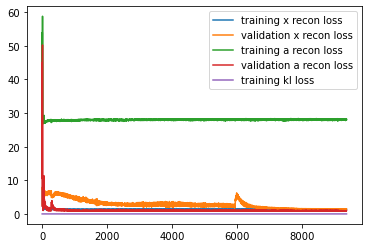

In [15]:
# plt.plot(np.arange(epochs),train_loss_ep)
# plt.plot(np.arange(epochs),val_loss_ep)
plt.plot(np.arange(epochs),train_loss_x_ep)
plt.plot(np.arange(epochs),val_loss_x_ep)
plt.plot(np.arange(epochs),train_loss_a_ep)
plt.plot(np.arange(epochs),val_loss_a_ep)
plt.plot(np.arange(epochs),train_loss_kl_ep)
# plt.plot(np.arange(epochs),train_loss_p_ep)
# plt.plot(np.arange(epochs),val_loss_p_ep)
# plt.plot(np.arange(epochs),np.array(train_loss_adv_ep)*advWeight)
# plt.plot(np.arange(epochs),np.array(val_loss_adv_ep)*advWeight)
# plt.plot(np.arange(epochs),np.array(train_loss_advD_ep)*advWeight)
# plt.plot(np.arange(epochs),np.array(val_loss_advD_ep)*advWeight)
# plt.plot(np.arange(epochs),np.array(train_loss_clf_ep)*clfweight)
# plt.plot(np.arange(epochs),np.array(val_loss_clf_ep)*clfweight)
# plt.ylim((0,2))
# plt.xlim((0,3000))
# plt.legend(['training loss','validation loss','training x recon loss','validation x recon loss','training kl loss'],loc='upper right')
plt.legend(['training x recon loss','validation x recon loss','training a recon loss','validation a recon loss','training kl loss','training classifier loss','validation classifier loss'],loc='upper right')
# plt.legend(['training protein recon loss','validation protein recon loss','training discriminator ae','validation discriminator ae','training discriminator d','validation discriminator d'],loc='upper right')
# plt.legend(['training a recon loss','validation a recon loss','training kl loss','training protein recon loss','validation protein recon loss','training discriminator ae','validation discriminator ae','training discriminator d','validation discriminator d'],loc='upper right')
# plt.legend(['training loss','validation loss','training x recon loss','validation x recon loss','training a recon loss','validation a recon loss','training kl loss','training discriminator ae','validation discriminator ae','training discriminator d','validation discriminator d'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3.jpg'))
plt.show()


In [19]:
# name='c13k20XA_07_dca'
# logsavepath='/mnt/xinyi/pamrats/log/train_gae_starmap/'+name
# with open(os.path.join(logsavepath,'val_loss_a'), 'rb') as output:
#     val_loss_a_ep=pickle.load(output)
np.argmin(val_loss_a_ep[:])
# # np.where(np.logical_not(np.isfinite(val_loss_ep[:])))
# val_loss_a_ep[8700]
# torch.log(torch.tensor([1/0]))

9419

In [22]:
testepoch=9420
model.load_state_dict(torch.load(os.path.join(modelsavepath,str(testepoch)+'.pt')))
model.eval()
for s in sampleidx.keys():
    print(s)
    
    adj_norm=adjnormlist[s].cuda().float()
    adj_label=adj_list[s].cuda().float()
    features=featureslist[s+'X_'+training_sample_X].cuda().float()
    pos_weight=pos_weightlist[s]
    norm=normlist[s]
    
    if 'dca' in model_str:
        features_raw=features_raw_list[s+'X_raw'].cuda()
    num_nodes,num_features = features.shape
    maskpath=os.path.join(savedir,'trainMask',s+'_'+maskedgeName+'_seed'+str(seed)+'.pkl')
    if useSavedMaskedEdges and os.path.exists(maskpath):
#         print('opening saved')
        with open(maskpath, 'rb') as input:
            maskedgeres = pickle.load(input)
    else:
        # construct training, validation, and test sets
        maskedgeres= preprocessing.mask_nodes_edges(features.shape[0],testNodeSize=testNodes,valNodeSize=valNodes)
        with open(maskpath, 'wb') as output:
            pickle.dump(maskedgeres, output, pickle.HIGHEST_PROTOCOL)
    train_nodes_idx,val_nodes_idx,test_nodes_idx = maskedgeres
    
    if s in training_samples:
        test_nodes_idx_s=test_nodes_idx
    else:
        test_nodes_idx_s=torch.tensor(np.arange(num_nodes))
        
#     adj_decode=None
#     if adj_decodeName == 'gala':
#         adj_decode=preprocessing.preprocess_graph_sharp(adj)

    if adj_decodeName==None:
        adj_recon,mu,logvar,z, features_recon = model(features, adj_norm)
    else:
        adj_decode=adj_decode.cuda()
        adj_recon,mu,logvar,z, features_recon = model(features, adj_norm,adj_decode)
    if adv and (s in list(sampleLabellist_ae.keys())):
        sampleLabel_ae=sampleLabellist_ae[s].cuda().float()
        modelAdv.eval()
        advOut=modelAdv(z)
    if 'dca' in model_str:
        if 'NB' in name:
            loss_x_test=loss_x(features_recon, features,test_nodes_idx,XreconWeight)
        else:
            loss_x_test=loss_x(features_recon, features,test_nodes_idx_s,XreconWeight,ridgeL,features_raw)
    else:
        loss_x_test=loss_x(features_recon, features,test_nodes_idx_s,XreconWeight,mse)
    loss_a_test=loss_a(adj_recon, adj_label, pos_weight, norm,test_nodes_idx_s)
    loss_test = loss_x_test+loss_a_test
    
    if adv and (s in list(sampleLabellist_ae.keys())):
        loss_adv_test=loss_adv(advOut,sampleLabel_ae,test_nodes_idx)
        print('loss_adv_test: {:.4f}'.format(loss_adv_test.item()))
        
    print('test results',
          'loss_test: {:.4f}'.format(loss_test.item()),
          'loss_x_test: {:.4f}'.format(loss_x_test.item()),
          'loss_a_test: {:.4f}'.format(loss_a_test.item()))
#          'loss_adv_test: {:.4f}'.format(loss_adv_test.item()))
    if protein:
        test_nodes_idx_s_genes=torch.clone(test_nodes_idx_s)
        test_nodes_idx_s_genes[2112:]=0
        test_nodes_idx_s_proteins=torch.clone(test_nodes_idx_s)
        test_nodes_idx_s_proteins[:2112]=0
        if 'dca' in model_str:
            loss_genes_test=loss_x(features_recon, features,test_nodes_idx_s_genes,XreconWeight,ridgeL,features_raw)
            loss_proteins_test=loss_x(features_recon, features,test_nodes_idx_s_proteins,XreconWeight,ridgeL,features_raw)
        print('loss_x_genes: {:.4f}'.format(loss_genes_test.item()),
          'loss_x_proteins: {:.4f}'.format(loss_proteins_test.item()))
    if 'dca' in model_str:
        features_raw=features_raw.cpu()

   

disease13
test results loss_test: 1.9044 loss_x_test: 1.4423 loss_a_test: 0.4621
control13
test results loss_test: 1.8180 loss_x_test: 1.3504 loss_a_test: 0.4676
disease8
test results loss_test: 1.7158 loss_x_test: 1.2725 loss_a_test: 0.4433
control8
test results loss_test: 1.9560 loss_x_test: 1.3937 loss_a_test: 0.5623
